# Projet n°3: Organisme de santé publique

# Introduction

L'agence Santé publique France souhaite rendre les données de santé publique plus accessibles pour qu’elles soient utilisables par ses agents. L'analyse est fondée sur le jeu de données Open Food. Cette analyse s'inscrit dans le contexte d'un problème de santé publique: la surconsommation de sucre. "*Selon de nouvelles lignes directrices, l’Organisation mondiale de la Santé recommande de ramener l’apport en sucres libres à moins de 10% de la ration énergétique totale chez l’adulte et l’enfant. Il serait encore meilleur pour la santé de réduire l’apport en sucres à moins de 5% de la ration énergétique totale, soit à 25 grammes (6 cuillères à café) environ par jour.*" [1]

Afin d'éradiquer ce problème de santé publique, les agents cherchent à faire de la pédagogie chez les plus jeunes (**écoles primaires et collèges**) car les bonnes habitudes prises par les enfants seront à la fois bénéfiques pour toute leur famille mais également pour eux-mêmes sur le long terme. Sensibiliser les enfants est le meilleur moyen de venir à bout de ce problème. La surconsommation de sucre est liée à une méconnaissance des principes fondamentaux d'une alimentation saine. On pourrait alors se dire que de transmettre ces principes aux plus jeunes serait le meilleur moyen de venir à bout de cette crise. Cependant, la nutrition est assez complexe et il est parfois compliqué de se retrouver dans l'immense quantité de produits présents dans les supermarchés. Comment apprendre aux enfants et aux adolescents les principes fondamentaux d'une alimentation saine? En utilisant les outils déjà à notre disposition à savoir: **les nutriscores.**

Ainsi, la problématique à laquelle seront confrontés les agents de santé publique et qui guidera notre analyse est la suivante: 
- **Aider les enfants et les adolescents à interpréter les score nutritionnels: savoir comment ils sont faits et porter un oeil critique à leur égard.** Un sous-objectif est de faire comprendre aux enfants comment le nutriscore peut les aider à réduire leur consommation de sucre.

# I. Faire la connaissance du nutriscore

## I.A. Forme du jeu de données

### Informations générales sur le tableau

Les variables pertinentes pour l'analyse sont identifiées:<br/>
<ul><li> En fonction de notre objectif décrit plus haut</li>
    <li>En fonctions de la forme des variable elle-même (_tags, _100g, _fr, _n). Je me suis appuyé sur les descriptions du document fourni dans l'appel à projet</li></ul>

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import exploration as ex
import numpy as np

# Tableau de données initial
data = pd.read_csv("C:/Users/valen/sante_publique/fr.openfoodfacts.org.products.csv", sep="\t", low_memory=False)

# Tableau qu'on utilisera pour le nettoyage
df = data.copy()

In [2]:
# Sélection des variables en fonction de leur description fournie dans le document
df = ex.selection_variables(data, ['_100g','_n','_t','_fr'], autres=True, autres_variables=['ingredients_text','product_name','serving_size']).copy()

In [3]:
ex.tableau_apercu([data,df],['data','df'])

,nom_tableau,lignes,variables,nbr_var_quanti,nbr_var_quali
0,data,320772.0,162.0,106.0,56.0
1,df,320772.0,136.0,105.0,31.0


### Identification des valeurs manquantes

**Premièrement:**<br/>
On élimine toutes les colonnes qui ne sont pas renseignées ou qui ont un facteur de remplissage inférieur à 1%.

In [4]:
# Toutes les colonnes qui ont un facteur de remplissage inférieur à 1%.
valeurs_manquantes = ex.missing_frame(df)
variables_nulles = valeurs_manquantes[valeurs_manquantes['facteur_remplissage']<=1]

In [5]:
# Suppression des variables qui ont un facteur de remplissage nul ou inférieur à 1%
variables_supprimees = variables_nulles['nom_colonne'].values
df = df.drop(variables_supprimees,axis=1)

In [6]:
# Aperçu de data_exploitable
ex.tableau_apercu([df],['df'])

,nom_tableau,lignes,variables,nbr_var_quanti,nbr_var_quali
0,df,320772.0,64.0,34.0,30.0


**Deuxièmement:**<br/>

In [7]:
import seaborn as sns

Text(0.5, 1.0, 'Visualisation des valeurs manquantes dans le dataset')

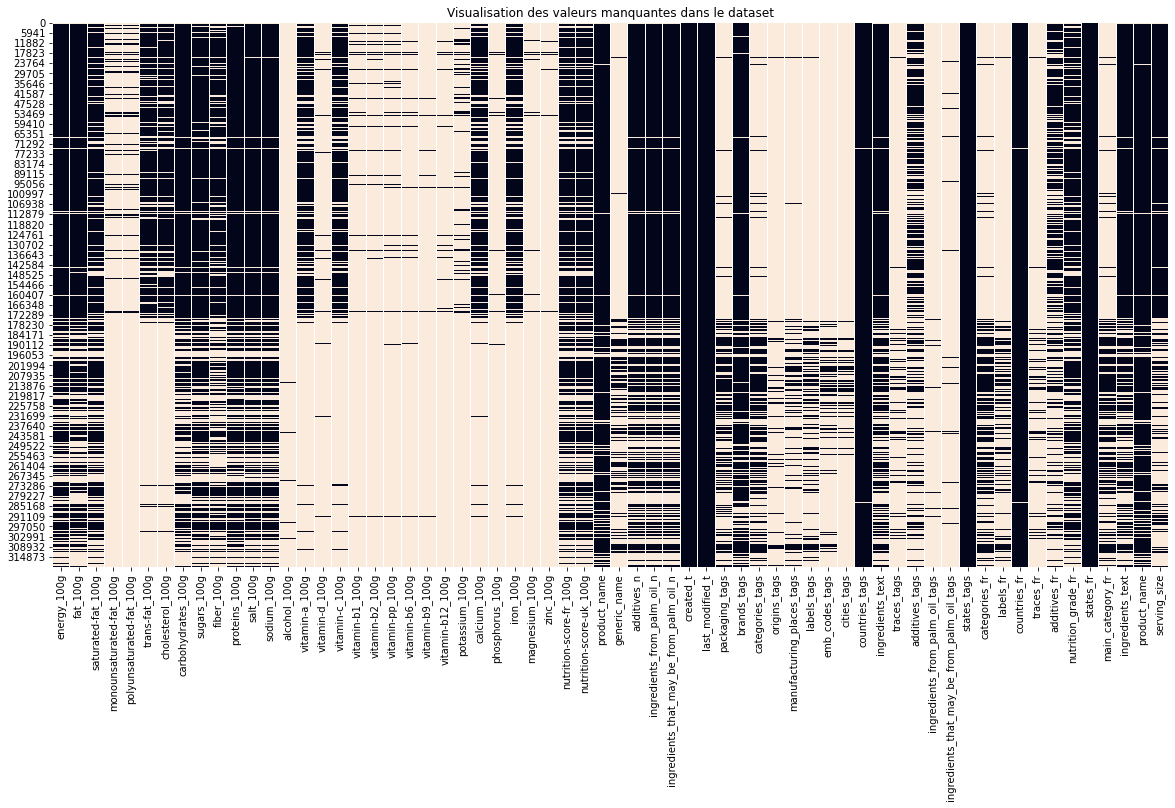

In [8]:
# Heatmap, visualisation des valeurs manquantes dans le tableau
#plt.figure(figsize=(20,10))
#sns.heatmap(df.isna(), cbar=False)
#plt.title('Visualisation des valeurs manquantes dans le dataset')

**Constat concernant les valeurs manquantes:**<br/>
1. Le tableau est en grande partie remplie de valeurs manquantes. Dans la suite, on va identifier ces variables qui ont très peu ou aucune valeur renseignée puis on va les supprimer.
2. Pour l'instant, la heatmap n'est pas assez lisible pour repérer des groupes de variables qui seraient **potentiellement** liés entre eux. Ces groupes là apparaissent sur la heatmap en formant des barres noires.
3. Il semblerait que les variables de type "valeur nutritionnelle pour 100g" soient les moins renseignées.

**Troisièmement:**<br/>
On va tenter d'identifier les variables qui contiennent les mêmes informations. Dans le document fourni avec l'appel à projet, il semblerait que les variables de type "_fr" et de type "_tags" soient toujours en couple. Si c'est le cas et qu'elles ont le même nombre de valeurs renseignées, on ne gardera que les variables de type "_tags" plus adaptées à l'analyse de données. On ne gardera que "nutrition_grade_fr" qui est une variable cible.

In [9]:
# Sélection des variables de type '_tags' et '_fr'
type_tags = ex.selection_variables(df,['_tags'])
type_fr = ex.selection_variables(df,['_fr'])

In [12]:
# Suppression des variables qui contiennent '_fr'
df = ex.suppression_variables(df,['_fr'],exceptions=True,exceptions_variables=['nutrition_grade_fr','ingredients_from_palm_oil_n'])

In [13]:
# Aperçu du tableau
ex.tableau_apercu([df],['df'])

,nom_tableau,lignes,variables,nbr_var_quanti,nbr_var_quali
0,df,320772.0,54.0,33.0,21.0


### Identification des variables principales 

---
<div id=categ></div>

**Catégorie 1 (celles prises en compte par le nutriscore):**<br/>
1. **Energie**:
    - energy_100g
2. **Graisses (saturées ou non)**: 
    - fat_100g
    - saturated-fat_100g
    - monounsaturated-fat_100g
    - polyunsaturated-fat_100g
    - trans-fat_100g
3. **Glucides (sucres simples, fibres et amidon)**: 
    - carbohydrates_100g
    - sugars_100g
    - fiber_100g
    - starch_100g
4. **Protéines**: 
    - proteins_100g
5. **Sel**: 
    - sodium_100g

**Catégorie 2 (celles qui ne sont pas prises en compte par le nutriscore):**<br/>
1. **Additifs**: 
    - additives_n
    - additives_tags (pour trouver les additifs nocifs)
2. **Degré de transformation d'un aliment**: 
    - ingredients_text (pour trouver les ingrédients transformés)
3. **Portion recommandée**:
    - serving_size

In [14]:
# Variables relatives à la graisses
graisses = ['fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'trans-fat_100g']

# Variables relatives aux glucides
glucides = ['carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'starch_100g']

# Variables relatives aux additifs
additifs = ['additives_n', 'additives_tags']

# Variable de la catégorie 1
categorie1 = ['energy_100g','proteins_100g', 'sodium_100g'] + graisses + glucides

# Variables de la catégorie 2
categorie2 = additifs + ['ingredients_text', 'serving_size']

### Analyser la forme des variables principales

**Premièrement:**<br/>
Les variables de type "valeur nutritionnelle pour 100g".

In [15]:
# Variables type: "_100g"
df['sugars_100g'].describe()

count    244971.000000
mean         16.003484
std          22.327284
min         -17.860000
25%           1.300000
50%           5.710000
75%          24.000000
max        3520.000000
Name: sugars_100g, dtype: float64

**Constat:**<br/>
On constate que certaines valeurs sont négatives et d'autres sont très supérieures à 100. Or, cette variable et toutes celles qui finissent par **'_100g'** sont des masses en **grammes** comprisent entre **0 et 100**. On va donc enlever pour toutes ces variables les valeurs qui sont inférieures à 0 et supérieures à 100. En ce qui concerne l'énergie, on va garder les valeurs comprises entre 0kJ et 3800kJ (900kcal) qui est la teneur calorique la plus élevée pour un aliment atteinte pour certaines huiles comme l'huile d'olive.

In [16]:
# Sélection des variables de type 'quantité pour 100g'
data_100g = ex.selection_variables(df,['_100g'])

# On supprime energy_100g qui peut prendre des valeurs supérieures à 100kcal
data_100g = data_100g.drop('energy_100g', axis=1)

# On enlève les outliers pour ces variables
for col in data_100g.columns.values:
    df[col]=ex.sans_outliers(df,col,borne_inf=False,nouvelle_borne_inf=0,borne_sup=False,nouvelle_borne_sup=100)

# On enlève les outliers pour energy_100g (0kcal à 900kcal soit 3800kJ)
df['energy_100g'] = ex.sans_outliers(df, 'energy_100g', borne_inf=False, nouvelle_borne_inf=0, borne_sup=False, nouvelle_borne_sup=3800)

# Affichage permettant de vérifier si le nettoyage a bien été fait. 
df['fat_100g'].describe()

count    243887.000000
mean         12.725256
std          17.503695
min           0.000000
25%           0.000000
50%           5.000000
75%          20.000000
max         100.000000
Name: fat_100g, dtype: float64

**Deuxièmement:**<br/>
Etude de la forme de la variable "servin_size".

**Opérations de transformation de la variable serving_size:**<br/>
On transforme la colonne serving_size en colonne numérique. Cette opération s'implifiera la suite de l'analyse. On aurait pu encoder cette variable  par la suite mais comme il y a des indication en plus de la masse, plusieurs catégories différentes auraient été crées pour la même portion. Choisir de transformer cette variable en variable numérique "à la main" permettra de mieux conserver l'information.

In [19]:
# On garde les 5 premiers caractères de chaque string dans la colonne serving_size.
df.serving_size = df.serving_size.str[0:4]

# On enlève les 'g', 'ml','m','l' et on remplace les ',' par des points.
df.serving_size = df.serving_size.str.replace("g","")
df.serving_size = df.serving_size.str.replace("m","")
df.serving_size = df.serving_size.str.replace("ml","")
df.serving_size = df.serving_size.str.replace(",",".")

# On met les valeurs qui sont en cl en ml
for val in df.serving_size.values:
    val=str(val)
    if 'cl' in val:
        val=val[:-2] +'0'
        
# On transforme la colonne en colonne numérique.
df.serving_size = pd.to_numeric(df.serving_size, errors='coerce')

**Bilan de l'opération de transformation:**<br/>
En choisissant "errors='coerce'", nous avons mis des Nan là où il y aurait eu un problème pour la transformation de la variable en variable numérique. Finalement nous avons une colonne qui a un facteur de remplissage de 63,7% contre 65,8% avant l'opération de transformation. De plus en affichant les premières lignes de la colonne il semblerait que l'opération se soit bien passée. Si durant l'opération nous n'avons pas distingué les unités des liquides et des solides c'est parce que nous condirérons que 1ml est environ égal à 1g. En effet, les boissons qui sont dans le tableau sont très largement composées d'eau.

**Troisièmement:**<br/>
La variable "ingredients_text" et la variable "additives_tags".

In [24]:
# Où se situent les colonnes 'ingredients_text'
result = np.where(df.columns.values=='ingredients_text')

# Indices des colonnes 'ingredients_text'
result = result[0]

# Découpe de la première colonne 'ingredients_text'
decoupe = df.iloc[:,result[0]].copy()

# Suppression des colonnes 'ingredients_text'
df.drop('ingredients_text',axis=1,inplace=True)

# Collage de la colonne 'ingredients_text'
df = pd.concat([df,decoupe],axis=1)

# Vérification
#df['ingredients_text'].head()

0                                                  NaN
1    Bananas, vegetable oil (coconut oil, corn oil ...
2    Peanuts, wheat flour, sugar, rice flour, tapio...
3    Organic hazelnuts, organic cashews, organic wa...
4                                      Organic polenta
Name: ingredients_text, dtype: object

**Quatrièmement:**<br/>
La variable "additives_n".

In [26]:
# Modalités prises par la variable 'additives_n'
df['additives_n'].unique()

array([nan,  0.,  2.,  1.,  3.,  6.,  5.,  8.,  4., 10., 11.,  9.,  7.,
       13., 12., 18., 22., 19., 17., 25., 21., 14., 16., 20., 24., 23.,
       15., 26., 28., 27., 29., 31.])

**Le nombre d'additifs:**<br/>
Certains produits pocèdent jusqu'à 31 additifs! Le nombre d'additifs est un très bon indicateur pour juger de la nocivité d'un produit. En effet, lorsqu'il y a beaucoup d'additifs dans un produit la liste des ingrédients devient incompréhensibles, on a l'impression de lire un code secret: "E509, E950, E285 etc ...". Ce n'est généralement pas bon signe d'un point de vue santé! Mangeriez-vous un aliment dont vous ne savez pas ce qu'il y a l'intérieur? Il ne sera pas possible d'analyser tous les additifs présents dans la liste des produits ou de faire une liste exhaustive de tous les additifs nocifs parmi ceux qui existent mais cette variable donne tout de même une bonne indication sur le caractère nocif d'un aliment.

## I. B. Appréhender le nutriscore

### Trois sortes de nutriscore

D'après la problématique, la variable cible est le nutriscore. Cependant il y a 3 nutriscores différents dans le jeu de données: le nutriscore français classique, le nutriscore anglais et un nutriscore français expérimental fondé sur le nutriscore anglais. Pour savoir laquelle ou lesquelles étudier parmi ces 3 variables, essayons de les comprendre un peu plus. 

In [28]:
# On vérifie qu'il n'y a pas de valeurs aberrantes
df.nutrition_grade_fr.unique()

array([nan, 'd', 'b', 'c', 'a', 'e'], dtype=object)

In [29]:
# Valeurs manquantes
ex.missing_frame(df,get_row=True,row_name='nutrition_grade_fr')

,nom_colonne,nbr_val_manquantes,facteur_remplissage
34,nutrition_grade_fr,99562,68.961755


In [30]:
# Répartition des nutriscores
df.nutrition_grade_fr.value_counts()

d    62763
c    45538
e    43030
a    35634
b    34245
Name: nutrition_grade_fr, dtype: int64

In [31]:
# Nutriscore français expérimental
df['nutrition-score-fr_100g'].head()

0     NaN
1    14.0
2     0.0
3    12.0
4     NaN
Name: nutrition-score-fr_100g, dtype: float64

In [32]:
# Nutriscore uk
df['nutrition-score-uk_100g'].head()

0     NaN
1    14.0
2     0.0
3    12.0
4     NaN
Name: nutrition-score-uk_100g, dtype: float64

In [33]:
# Valeurs manquantes
ex.missing_frame(df,get_row=True,row_name='nutrition-score-fr_100g')

,nom_colonne,nbr_val_manquantes,facteur_remplissage
31,nutrition-score-fr_100g,135268,57.830484


**Remarque:**<br/>
Les variables cibles ont un nombre de valeurs renseignées assez élevé pour pouvoir travailler correctement dessus. La variable **nutrition_grade_fr** est une variable qualitative et les variables **nutrition-score-fr_100g** et **nutrition-score-uk_100g** sont des variables quantitatives. De plus, à l'affichage des premières lignes on constate que ces deux nutriscores sont semblent être égaux. Pour en être sûr, on affiche leur distribution.

Text(0.5, 1.0, 'Répartiton des individus par nutriscore')

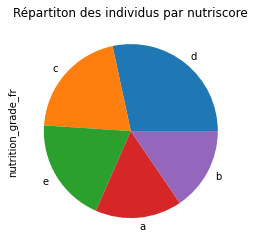

In [34]:
# Nutriscore français classique
df.nutrition_grade_fr.value_counts().plot.pie()
plt.title('Répartiton des individus par nutriscore')

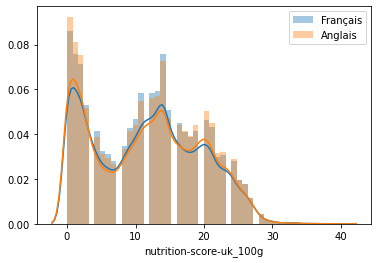

In [35]:
# Comparaison du nutrition-score-fr et du nutrition-score-uk
sns.distplot(df['nutrition-score-fr_100g'], label='Français')
sns.distplot(df['nutrition-score-uk_100g'], label='Anglais')
plt.legend()

In [36]:
# Suppression de nutrition-score-uk_100g
df.drop('nutrition-score-uk_100g', axis=1, inplace=True)

In [37]:
# Informations générales sur le nutrition-score-fr_100g
df['nutrition-score-fr_100g'].describe()

count    185504.000000
mean         11.587324
std           7.783573
min           0.000000
25%           4.000000
50%          12.000000
75%          18.000000
max          40.000000
Name: nutrition-score-fr_100g, dtype: float64

In [38]:
# Asymétrie et coefficient d'applatissement
print("Skewness: {}".format(df['nutrition-score-fr_100g'].skew()))
print("Kurtosis: {}".format(df['nutrition-score-fr_100g'].kurt()))

Skewness: 0.13809331805382988
Kurtosis: -0.9964118526768635


**Remarque:**<br/>
On a un skewness empirique supérieur à 0, cela signifie que la distribution s'étale légèrement vers la droite et on a un kurtosis empirique égal à -1 ce qui signifie que la distribution est assez aplatie.

**Les nutriscores:**<br/>
Il est difficile d'interpréter les mesures sur le nutriscore que nous venons de faire de manière isolée. On sait simplement qu'il y a deux types de nutriscore: le classique avec une notation avec des lettres allant de A (très bon) à E (très mauvais) et l'expérimental avec une notation par points allant de 0 (très bon) à 40 (très mauvais). Pour simplifier la suite de l'analyse, on va remplacer les lettres a, b, c, d et e par des chiffres: 0, 1, 2, 3 et 4.

In [39]:
# Transforme nutrition_grade_fr en variable numérique
df['nutrition_grade_fr'] = df['nutrition_grade_fr'].replace(['a','b','c','d','e'],[0,1,2,3,4])
#df['nutrition_grade_fr'].head()

0    NaN
1    3.0
2    1.0
3    3.0
4    NaN
Name: nutrition_grade_fr, dtype: float64

### Nutriscore et variables principales

On va maintenant essayer de savoir s'il n'y a pas des relations qui existent entre le nutriscore et les autres variables principales: energy_100g, fat_100g, sodium_100g, carbohydrates_100g, sugars_100g, 'fiber_100g', proteins_100g, serving_size et additives_n. De plus, les scatterplot vont nous permettre facilement ce qu'est un outliers pour chaque variable.

In [40]:
# 1000 points pris au hasard dans les variables continues pour afficher les scatterplot
n = 1000
target = 'nutrition-score-fr_100g'

sample_energy = df.loc[:,['energy_100g',target]].sample(n)
sample_fat = df.loc[:, ['fat_100g', target]].sample(n)
sample_sodium = df.loc[:, ['sodium_100g', target]].sample(n)
sample_fiber = df.loc[:, ['fiber_100g', target]].sample(n)
sample_carbs = df.loc[:, ['carbohydrates_100g', target]].sample(n)
sample_sugars = df.loc[:, ['sugars_100g', target]].sample(n)
sample_proteins = df.loc[:, ['proteins_100g', target]].sample(n)
sample_serving_size = df.loc[:, ['serving_size', target]].sample(n)

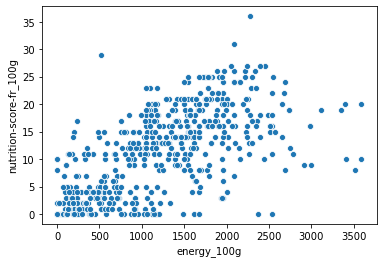

In [41]:
# Nutriscore en fonction des kcal
sns.scatterplot(x='energy_100g', y=target, data=sample_energy)

**Analyse:**<br/>
Il semblerait qu'il y ait une relation linéaire entre le nutriscore et la variable energy_100g. Ce qui serait cohérent puisqu'on se doute que plus les kcal augmentent plus le nutriscore aura tendance à être élevé (donc mauvais).

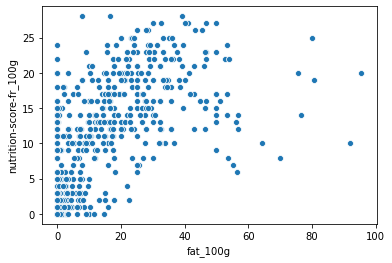

In [42]:
# Nutriscore en fonction de fat
sns.scatterplot(x='fat_100g', y=target, data=sample_fat)

**Analyse:**<br/>
Il semblerait qu'il y ait une relation linéaire avec un coefficient directeur assez élevé. On remarque également la présence d'outliers: les points en x=100 qui doivent correspondre à des huiles.

---
<div id=sodium></div>

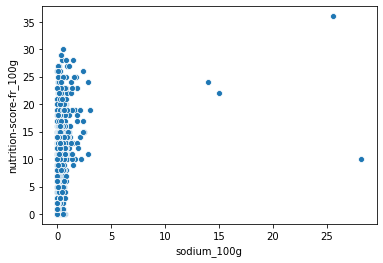

In [43]:
# Nutriscore en fonction de sodium
sns.scatterplot(x='sodium_100g', y=target, data=sample_sodium)

**Analyse:**<br/>
Le fait que les teneurs en sel pour 100g soient très concentrées autour de 2g permet de distinguer facilement sur le graphique les outliers. Sachant que pour un paquet de chips le taux de sel se situe autour de 10g pour 100g environ, on peut facilement considérer les points ayant des abscisses supérieures à 10 comme outliers surtout que ces points n'ont étonnamment pas de nutriscore élevé. En effet un aliment très salé devrait avoir un mauvais nutriscore.

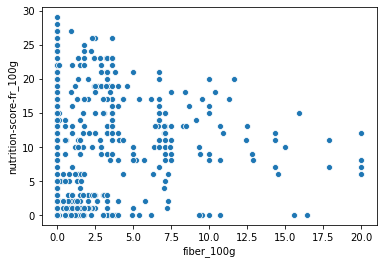

In [44]:
# Nutriscore en fonction de sodium
sns.scatterplot(x='fiber_100g', y=target, data=sample_fiber)

**Analyse:**<br/>
Le nutriscore semble devenir meilleur quand la quantité de fibres décroit. On note la présence d'outliers pour les abscisses élevés (au-delà de x=20). Par exemple, dans l'avoine il y a 11g de fibres pour 100g et l'avoine est déjà considéré comme un produit très riche en fibres. Le son de blé possède 40g de fibres pour 100g mais il s'agit là d'un cas exceptionnel.

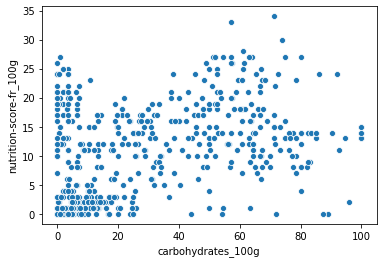

In [45]:
# Nutriscore en fonction des hydrates de carbone
sns.scatterplot(x='carbohydrates_100g', y=target, data=sample_carbs)

**Analyse:**<br/>
Aucune relation ne semble se distinguer. 

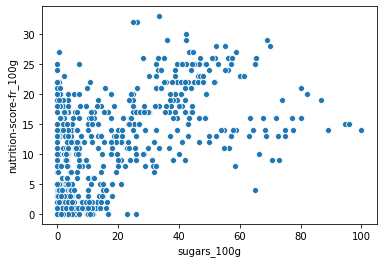

In [46]:
# Nutriscore en fonction du sucre
sns.scatterplot(x='sugars_100g', y=target, data=sample_sugars)

**Analyse:**<br/>
On note la présence d'un point d'abscisse x=100 ce qui correspond surement à du sucre en grain.

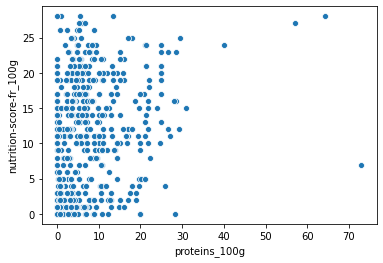

In [47]:
# Nutriscore en fonction des protéines
sns.scatterplot(x='proteins_100g', y=target, data=sample_proteins)

**Analyse:**<br/>
On ne remarque pas de relation particulière. Il y a des outliers (abscisses autour de 80) qui correspondent surement à des produits type protéines en poudre.

---
<div id=servXnutriscore></div>

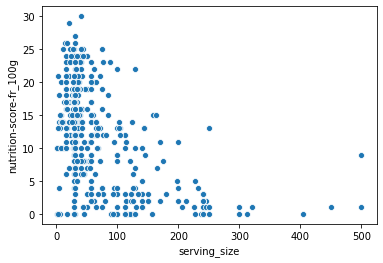

In [48]:
# Nutriscore en fonction de la portion recommandée
sns.scatterplot(x='serving_size', y=target, data=sample_serving_size)

**Analyse:**<br/>
Les produits dont on recommande les portions les plus petites sont aussi ceux qui ont tendance à avoir des nutriscore élevés donc mauvais ce qui semble logique.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

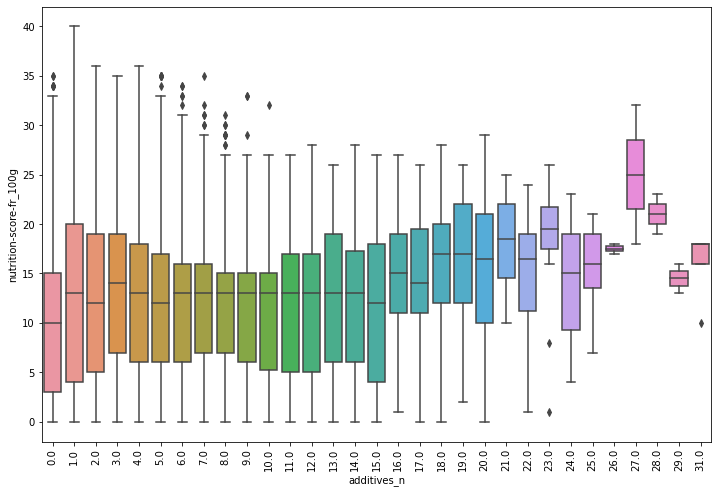

In [49]:
# Nutriscore et nombre d'additifs
plt.figure(figsize=(12,8))
sns.boxplot(x='additives_n',y=target,data=df)
plt.xticks(rotation=90)

**Analyse:**<br/>
Le nutriscore semble augmenter avec le nombre d'additifs présents dans l'aliment cependant cette tendance n'est pas notable. Ceci s'explique par le fait que le nutriscore ne prenne pas en compte le nombre d'additifs ni leur nocivité. Ainsi, on peut voir un aliment qui possède 23 additifs mais qui a un nutriscore proche de 0 (donc un bon nutriscore).

### Corrélations entre toutes les variables

Nous ne venons d'étudier que quelques variables de notre tableau de données, celles qu'on ne peut pas ignorer dans le cadre de notre objectif. Cependant, le jeu de données possède 64 variables et pour avoir faire une analyse exhaustive, il est nécessaire de pouvoir observer les relations entre toutes les variables. Nous allons donc afficher la matrice des corrélations du tableau.

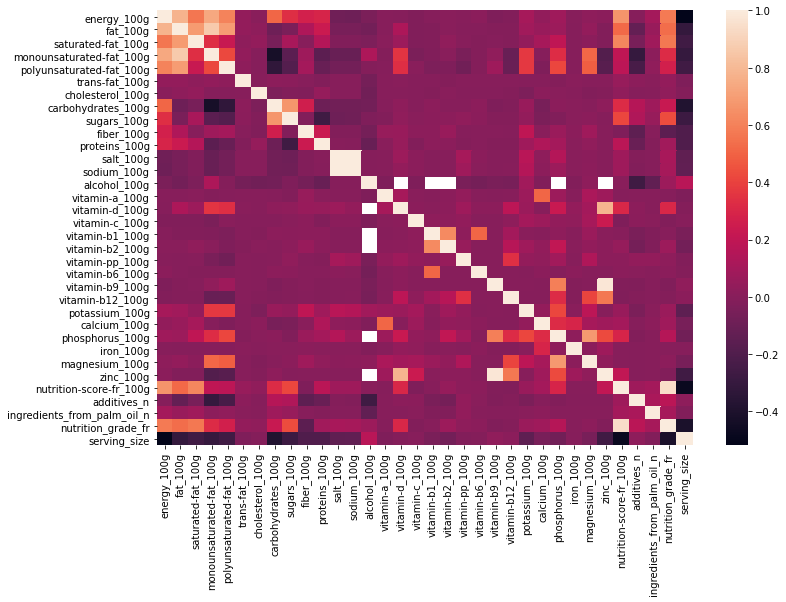

In [50]:
# Corrélations entre toutes les variables
#corr_matrix = df.corr()
#plt.figure(figsize=(12,8))
#sns.heatmap(corr_matrix, vmax=1)

In [51]:
# Valeurs manquantes de sodium_100g et salt_100g
print('Sel: {}'.format(df.salt_100g.isna().sum()))
print('Sodium: {}'.format(df.sodium_100g.isna().sum()))

Sel: 65420
Sodium: 65343


In [52]:
# Suppression des variables indiquées dans le paragraphe 'traitement des variables colinéaires' ci-dessus
df = df.drop(['salt_100g',
              'saturated-fat_100g', 
              'monounsaturated-fat_100g', 
              'polyunsaturated-fat_100g', 
              'trans-fat_100g',
              'carbohydrates_100g',
              'nutrition-score-fr_100g',
              'energy_100g'], axis=1)

<strong>Mise à jour de nos listes qui contiennent les 2 catégories décrites <a href=#categ>ici</a>.</strong>

In [53]:
# Variables relatives aux glucides
glucides = ['sugars_100g', 'fiber_100g']

# Variables relatives aux additifs
additifs = ['additives_n', 'additives_tags']

# Variable de la catégorie 1
categorie1 = ['proteins_100g', 'sodium_100g', 'fat_100g'] + glucides

# Variables de la catégorie 2
categorie2 = additifs + ['ingredients_text', 'serving_size']

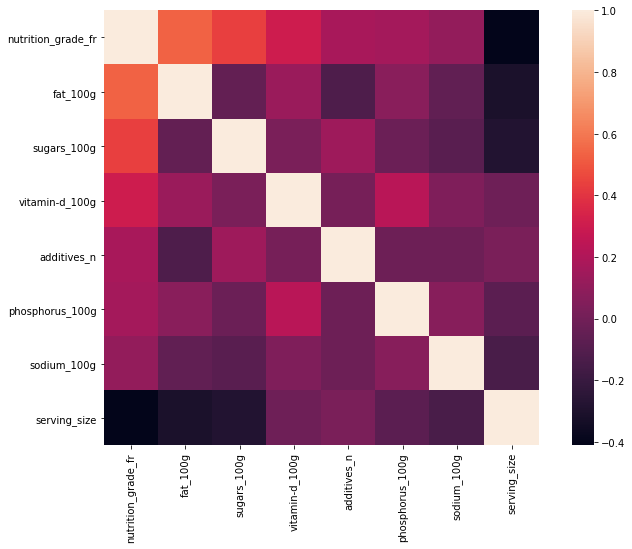

In [54]:
# Recalcul de la matrice des corrélations de df
#corr_matrix = df.corr()

# On choisit 6 variables les plus corrélées à 'nutrition_grade_fr'
#k1 = 7

# On choisit la variable la plus anticorrélée à 'nutrition_grade_fr'
#k2 = 1

# Les variables les plus corrélées et anticorrélées à 'nutrition_grade_fr'
#cols1 = corr_matrix.nlargest(k1, 'nutrition_grade_fr')['nutrition_grade_fr'].index
#cols2 = corr_matrix.nsmallest(k2, 'nutrition_grade_fr')['nutrition_grade_fr'].index
#cols = list(cols1) + list(cols2)

# Matrice des corrélations les plus fortes
#corrmat_nutriscore = df[cols].corr()
#plt.figure(figsize=(12,8))
#sns.heatmap(corrmat_nutriscore, 
            #cbar=True, 
            #square=True,
            #yticklabels=cols, 
            #xticklabels=cols)

## I. C. Les variables caractérisant le nutriscore.

### Catégorie 1: celles que le nutriscore prend en compte

In [1]:
from ipywidgets import (widgets, interact, interactive)

In [2]:
import pickle

with open("transfer_df","rb") as fichier:
    df_depickler=pickle.Unpickler(fichier)
    df=df_depickler.load()
    
with open("transfer_data","rb") as fichier:
    data_depickler=pickle.Unpickler(fichier)
    data=data_depickler.load()
    
with open("transfer_categorie1","rb") as fichier:
    categorie1_depickler=pickle.Unpickler(fichier)
    categorie1=categorie1_depickler.load()
    
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import exploration as ex
import numpy as np
import seaborn as sns

In [3]:
def plot_categorie_1(**arg):
    colonne = arg['colonne']
    plt.figure(figsize=(10,6))
    sns.distplot(df[colonne],label=colonne)
    plt.title('Distribution de la variable '+colonne)

In [4]:
colonne_widget = widgets.Dropdown(value='sugars_100g',
                                  options=categorie1,
                                  description='Variable:')
#display(colonne_widget)

**Sodium et fibres:**<br/>
Avant d'afficher les graphiques des distributions des variables, on supprime les outliers qu'on avait repéré <a href=#sodium>ici</a> pour les variables 'sodium_100g' et 'fiber_100g'.

In [5]:
# Suppression outliers sodium
#df['sodium_100g'] = ex.sans_outliers(df, 'sodium_100g', borne_inf=False, nouvelle_borne_inf=0)

In [6]:
# Suppression outliers fibres
#df['fiber_100g'] = ex.sans_outliers(df, 'fiber_100g', borne_inf=False, nouvelle_borne_inf=0)

In [7]:
interactive(plot_categorie_1,
            colonne=colonne_widget)

interactive(children=(Dropdown(description='Variable:', index=3, options=('proteins_100g', 'sodium_100g', 'fat…

**Analyse:**<br/>
<ul><li>Les variables 'sugars_100g', 'sodium_100g' et 'fat_100g' ont des distributions similaires avec une asymétrie positive très marquée (un grand nombre de valeurs à 0g) et un étalement long et épais vers les valeurs élevés de ces variables.</li>
    <li>La variable 'proteins_100g' a une distribution très asymétrique (positive) avec un étalement assez fin et assez court.</li>
    <li>La variable 'fiber_100g' est assez aplatie si on ne prend pas en compte le nombre très élevé d'aliments qui ne contiennent pas de fibre.</li></ul> 

In [59]:
# Aplatissement et Asymétrie
for col in categorie1:
    print('{} :\n\t Aplatissement: {}\n\t Asymétrie: {} '.format(col,
                                                                 df[col].kurt(),
                                                                 df[col].skew()))

proteins_100g :
	 Aplatissement: 8.387070546688543
	 Asymétrie: 2.1277236281269007 
sodium_100g :
	 Aplatissement: 0.457649915368628
	 Asymétrie: 1.08630078778745 
fat_100g :
	 Aplatissement: 6.1533989160463
	 Asymétrie: 2.1944490481494547 
sugars_100g :
	 Aplatissement: 2.228552133911979
	 Asymétrie: 1.6681265230209692 
fiber_100g :
	 Aplatissement: 0.5192426412208362
	 Asymétrie: 1.1575205323272117 


**Analyse:**<br/>
Lors de l'interprétation de ces résultats il faut avoir en tête que nos distributions sont assez éloignées de la distribution normale alors que ces valeurs permettent de faire des comparaisons à la distribution normale. Cependant, ces résultats restent intéressants et devront être pris en compte lors des tests d'hypothèses puisque la plupart peuvent être appliqués sous condition de normalité. <br/>
Toutes les distributions ont des skewness empiriques positifs ce qui confirme qu'elles sont toutes étalées à droite. Toutes les variables ont des kurtosis empiriques très élevés (même 0.5 est assez élevé) ce qui signifie qu'elles sont toutes moins aplaties que la distribution normale.

### Catégorie 2: celles que le nutriscore ne prend pas en compte

On va étudier les variables 'additives_n' et 'serving_size'. Ces deux variables ne sont pas prises en compte par le nutriscore mais elles sont nécessaires lorsque l'on désire connaître la qualité nutritionnelle d'un aliment.

In [62]:
# Description générale de 'serving_size'
df.serving_size.describe()

count    204423.000000
mean         80.729879
std          90.168823
min           0.000000
25%          28.000000
50%          42.000000
75%         112.000000
max        3000.000000
Name: serving_size, dtype: float64

In [63]:
# Suppression outliers pour 'serving_size'
df['serving_size'] = ex.sans_outliers(df, 'serving_size', borne_inf=False, nouvelle_borne_inf=0, borne_sup=False, nouvelle_borne_sup=300)

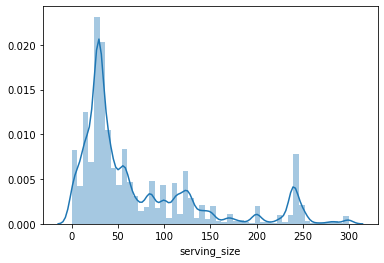

In [64]:
# Distribution de la variable 'serving_size'
sns.distplot(df.serving_size)

In [65]:
# Aplatissement et asymétrie
print('Serving size:\n Aplatissement: {} \n Asymétrie: {}'.format(df.serving_size.kurt(),
                                                                  df.serving_size.skew()))

Serving size:
 Aplatissement: 1.3362233508658496 
 Asymétrie: 1.4938392920127483


**Analyse:**<br/>
On remarque une distribution qui s'étale vers la droite avec deux bosses distinctes: la première à environ 40g et la deuxième à 250g. Les valeurs de kurtosis et skewness empiriques confirment ces observations.

In [66]:
# Informations générales sur additives_n
df.additives_n.describe()

count    248939.000000
mean          1.936024
std           2.502019
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          31.000000
Name: additives_n, dtype: float64

La moitié des produits renseignés possèdent un additif ou pas d'additif.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

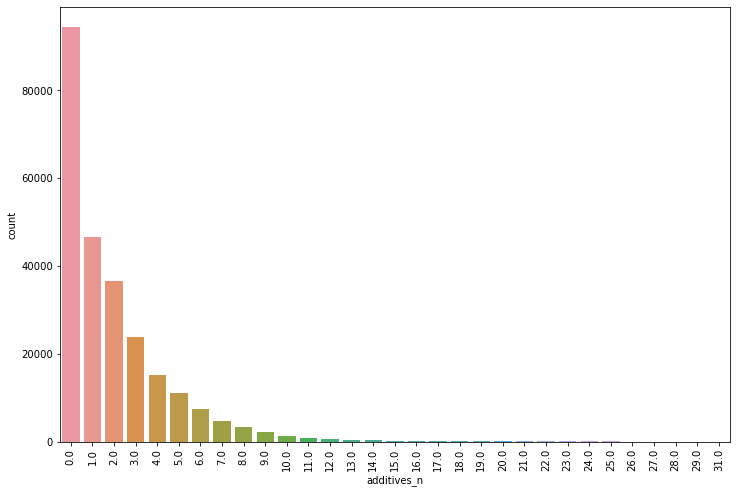

In [68]:
# Distribution de additives_n
plt.figure(figsize=(12,8))
sns.countplot(x='additives_n', data=df)
plt.xticks(rotation=90)

**Analyse:**<br/>
Au delà du nombre d'additifs, ce qui est important c'est de savoir s'ils sont nocifs ou pas. En effet, il vaut mieux 5 additifs inoffencifs qu'un seul dangereux. Nous distinguerons cet aspect dans la suite de l'analyse nous nous appuierons sur le travail de Corinne Gouget: *Additifs alimentaires danger!*.

### Conclusion de la première partie

Avant de conclure cette première partie et afin de terminer notre premier nettoyage du tableau, nous allons traiter les colonnes dupliquées ainsi que les lignes dupliquées s'il y en a.

In [82]:
# Colonnes dupliquées
for col in df.columns:
    result = np.where(df.columns.values==col)
    if len(result[0])!=1:
        print('{} aux indices : {} '.format(col, result[0]))

product_name aux indices : [22 41] 
product_name aux indices : [22 41] 


In [83]:
# Où se situent les colonnes 'product_name'
result = np.where(df.columns.values=='product_name')

# Indices des colonnes 'product_name'
result = result[0]

# Découpe de la première colonne 'product_name'
decoupe = df.iloc[:,result[0]].copy()

# Suppression des colonnes 'product_name'
df.drop('product_name',axis=1,inplace=True)

# Collage de la colonne 'product_name'
df = pd.concat([df,decoupe],axis=1)

# Vérification
df['product_name'].head()

0                Farine de blé noir
1    Banana Chips Sweetened (Whole)
2                           Peanuts
3            Organic Salted Nut Mix
4                   Organic Polenta
Name: product_name, dtype: object

In [85]:
# Suppression des lignes dupliquées, on garde la première.
df = df.drop_duplicates(keep="first")

# Nombre de lignes de data_exploitable
#df.shape[0]

320150

In [86]:
ex.tableau_apercu([df],['df'])

,nom_tableau,lignes,variables,nbr_var_quanti,nbr_var_quali
0,df,320150.0,43.0,26.0,17.0


**Remarque concernant les valeurs manquantes du dataset:**<br/>
L'étude du tableau dans cette partie nous a permis de constater qu'il y avait beaucoup de variables avec moins de 10% de valeurs renseignées. Ces variables sont majoritairement des vitamines et des minéraux. Ce sont des variables très spécifiques et les valeurs renseignées doivent correspondre à des types d'aliments particuliers. En effet, très peu de produits indiquent les teneurs en vitamines et minéraux. Généralement, les produits qui indiquent ces chiffres sont les céréales, les compléments alimentaires ou les boissons énergisantes. On pourrait étudier un sous-tableau, celui des vitamines et des minéraux qui aurait environ 32 000 lignes (10% de 320 000). En effet, ces variables, au même titre que les additifs, ne sont pas prises en compte par le nutriscore. Nous n'étudierons pas cet aspect dans notre étude mais il est important de soulever cette remarque.

**Conclusion:**<br/>
Cette première partie nous a permis de nous approprier le jeu de données et les variables pertinentes à analyser dans le cadre de notre objectif: comprendre le nutriscore et porter un regard critique à son égard. On a également fait un premier nettoyage du jeu de données en supprimant les variables qui ont moins de 1% de valeurs renseignées et en identifiant les variables source de multicolinéarité. D'après les matrices de corrélations qu'on a affichées, il ne semble pas y avoir de fortes corrélations linéaires sans colinéarité parmi les variables qui nous intéressent. Dans la suite de notre analyse nous allons étudier de manière plus précise nos variables principales afin de pouvoir énoncer des hypothèses que nous testerons ensuite. On va par exemple analyser les produits qui ont de mauvais nutriscores et comparer le taux de sucres simples ('sugars_100g') de ces derniers aux taux de sucres simples des produits ayant des bons nutriscores. Ces comparaisons vont nous permettent de savoir de manière rigoureuse s'il y a des différences **significatives** pour une variable donnée entre les produits ayant de bons et de mauvais nutriscores. Si les différences sont significatives, l'agent de santé publique pourra s'appuyer sur nos réultats pour conseiller aux enfants et aux adolescents **"Si vous voulez limiter votre consommation de X, vous pouvez vous fier au nutriscore. Par contre si vous voulez limiter votre consommation de Y les nutriscores ne sont pas forcément très adaptés."**

---
**Enregistrement des variables de la partie I.**

In [87]:
import pickle

with open("transfer_data","wb") as fichier:
    data_pickler=pickle.Pickler(fichier)
    data_pickler.dump(data)
    
with open("transfer_df","wb") as fichier:
    df_pickler=pickle.Pickler(fichier)
    df_pickler.dump(df)
    
with open("transfer_categorie1","wb") as fichier:
    categorie1_pickler=pickle.Pickler(fichier)
    categorie1_pickler.dump(categorie1)
    
with open("transfer_categorie2","wb") as fichier:
    categorie2_pickler=pickle.Pickler(fichier)
    categorie2_pickler.dump(categorie2)
    
with open("transfer_additifs","wb") as fichier:
    additifs_pickler=pickle.Pickler(fichier)
    additifs_pickler.dump(additifs)
    
    
with open("transfer_glucides","wb") as fichier:
    glucides_pickler=pickle.Pickler(fichier)
    glucides_pickler.dump(glucides)

**Fin enregistrement variables partie I**

---

# II. Tout savoir sur le nutriscore

---
**Début récupération des données pour la partie II.**

In [1]:
import pickle

with open("transfer_df","rb") as fichier:
    df_depickler=pickle.Unpickler(fichier)
    df=df_depickler.load()
    
with open("transfer_data","rb") as fichier:
    data_depickler=pickle.Unpickler(fichier)
    data=data_depickler.load()
    
with open("transfer_categorie1","rb") as fichier:
    categorie1_depickler=pickle.Unpickler(fichier)
    categorie1=categorie1_depickler.load()

with open("transfer_categorie2","rb") as fichier:
    categorie2_depickler=pickle.Unpickler(fichier)
    categorie2=categorie2_depickler.load()
    
with open("transfer_glucides","rb") as fichier:
    glucides_depickler=pickle.Unpickler(fichier)
    glucides=glucides_depickler.load()

with open("transfer_additifs","rb") as fichier:
    additifs_depickler=pickle.Unpickler(fichier)
    additifs=additifs_depickler.load()
    
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import exploration as ex
import numpy as np
import seaborn as sns

**Fin récupération des données**

---

## II. A. Première analyse en composantes principales

**Pourquoi réaliser une ACP?**<br/>
L'ACP va nous permettre d'avoir une vue d'ensemble de notre tableau en mettant en avant de nouvelles variables qui le synthétisent.

### Préparation des données pour l'ACP.

In [2]:
# Copie qui nous servira pour l'acp
data_acp1 = df.copy()

In [5]:
# Suppression des variables qualitatives
for col in data_acp1.columns:
    if data_acp1[col].dtypes == 'object':
        data_acp1.drop(col,axis=1,inplace=True)

**Traitement des valeurs manquantes:**<br/>
<ul><li>Pour la variable 'additives_n' on impute des 0 qui est la classe modale de cette variable.</li>
    <li>Pour la variable 'nutrition_grade_fr' on impute des -1 afin que les valeurs manquantes se distinguent sur les graphiques que nous allons afficher puisque nous allons utiliser 'nutrition_grade_fr' comme variable illustrative. Cela permettra de voir où se situent les aliments selon leur nutriscore sur les plans factoriels</li>
    <li>Partout ailleur on impute par la moyenne.</li></ul>

In [7]:
# Imputation de 0 pour la variable additives_n
data_acp1.additives_n.fillna(0, inplace=True)

# Imputation de -1 pour la variable nutrition_grade_fr
data_acp1.nutrition_grade_fr.fillna(-1, inplace=True)

# Imputation par la moyenne partout ailleurs
data_acp1 = data_acp1.fillna(data_acp1.mean())

In [10]:
# Il y aura donc au maximum 26 composantes
n_comp = 26

In [11]:
# Conversion des données en array
X_acp1 = data_acp1.values

In [12]:
# Sauvegarde des colonnes de data_acp
features = data_acp1.columns

**Variables illustratives:**<br/>
Dans le cadre de notre objectif on va distinguer 3 variables illustratives pour l'ACP:
<ul><li>le nutriscore: 'nutrition_grade_fr'</li>
    <li>le taux de sucre: très sucré, modérément sucré, peu sucré et pas sucré</li>
    <li>le taux de gras: très gras, modérément gras, pas très gras et sans matière grasse</li></ul>

In [13]:
# Discrétisation de 'sugars_100g' et 'fat_100g'
fat_disc = pd.qcut(data_acp1['fat_100g'], q=4, labels = range(4))
sugar_disc = pd.qcut(data_acp1['sugars_100g'], q=4, labels = range(4))

In [16]:
# Variables illustratives
nutriscore = [data_acp1.loc[ind, 'nutrition_grade_fr'] for ind in data_acp1.index ] # 1ère
sugar = [sugar_disc[ind] for ind in sugar_disc.index ] # 2ème
fat = [fat_disc[ind] for ind in fat_disc.index ] # 3ème

In [17]:
from sklearn import decomposition
from sklearn import preprocessing

In [18]:
# Centrage et réduction des données
X_acp1_scaled = preprocessing.StandardScaler().fit_transform(X_acp1)

In [19]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_acp1_scaled)

PCA(copy=True, iterated_power='auto', n_components=26, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [20]:
from functions import *

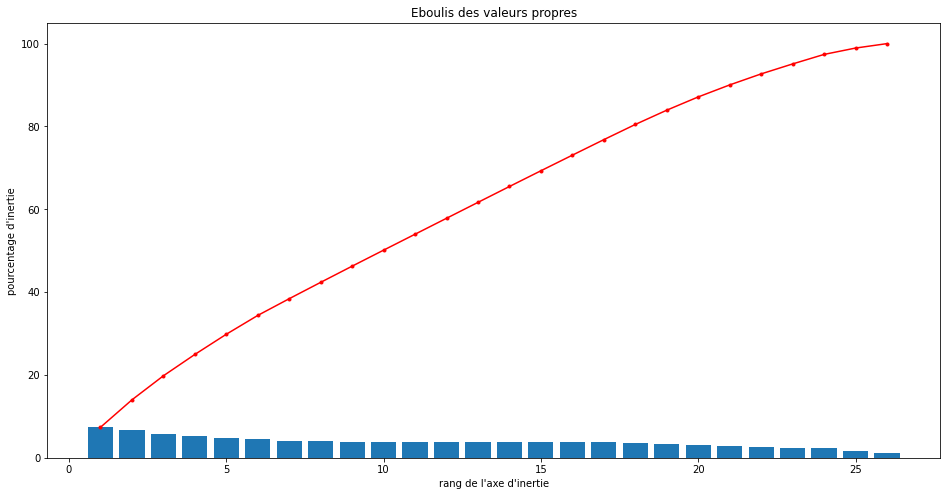

In [21]:
# Eboulis des valeurs propres
display_scree_plot(pca, freq_cumulee=True)

**Choix du nombre de composantes:**<br/>
On choisit de ne représenter que le premier plan factoriel car les autres axes ne représentent que très peu de variabilité.

### Réalistation de l'acp

In [22]:
# Récupération des composantes dans la variable pcs
pcs = pca.components_

# Coordonnées des individus projetés
X_acp1_projected = pca.transform(X_acp1_scaled)

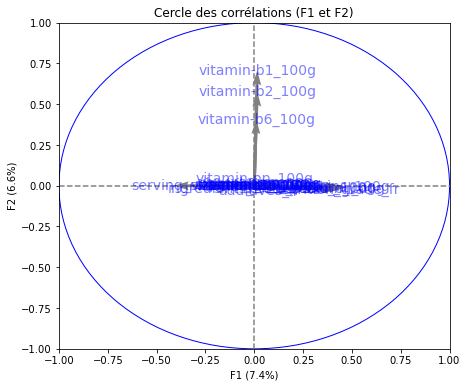

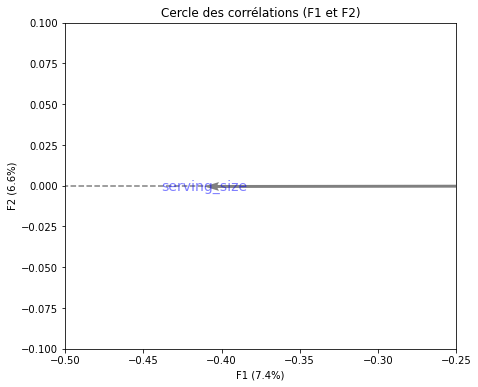

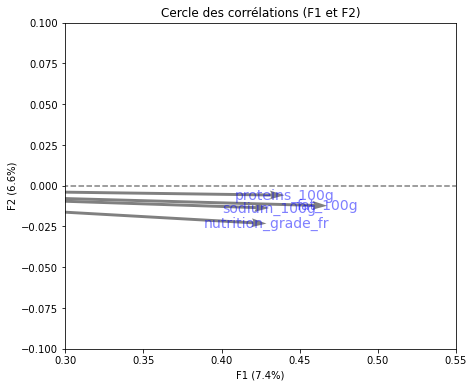

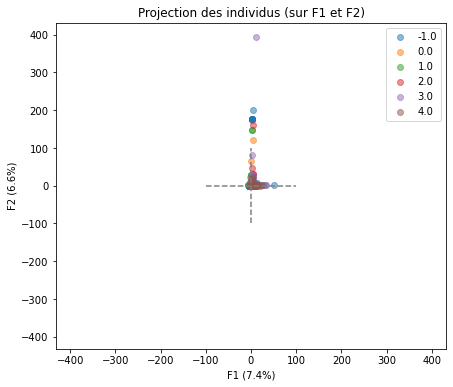

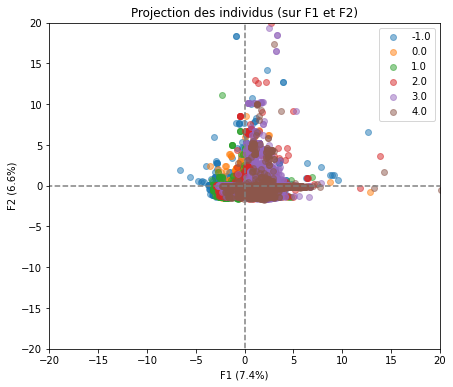

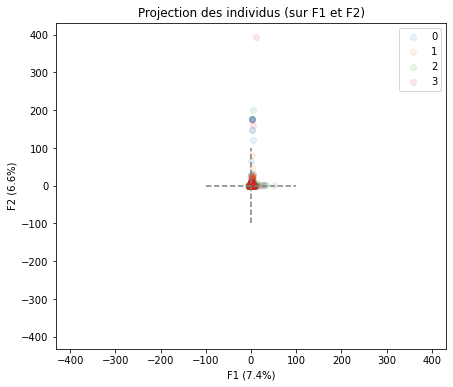

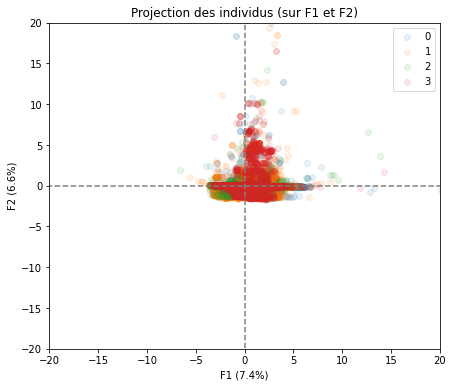

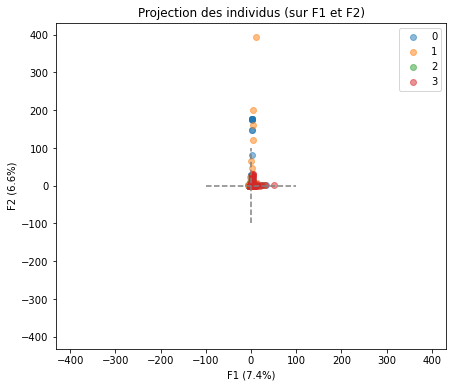

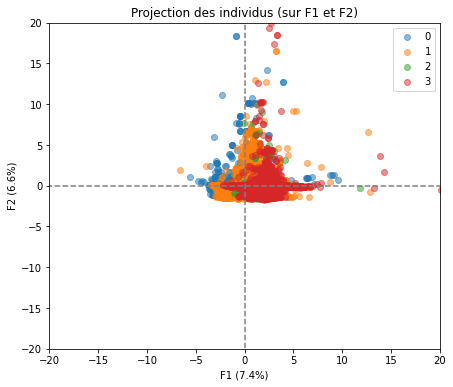

In [26]:
# Cercle F1/F2 des corrélations
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Cercle F1/F2 des corrélations ZOOM 1
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features), lims=(-0.5,-0.25,-0.1,0.1))

# Cercle F1/F2 des corrélations ZOOM 2
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features), lims=(0.3,0.55,-0.1,0.1))


# Projection des individus sur F1/F2 illustration nutriscore
display_factorial_planes(X_acp1_projected, n_comp, pca, [(0,1)] ,illustrative_var = nutriscore, alpha=0.5)

# Projection des individus sur F1/F2 nutriscore ZOOM
display_factorial_planes(X_acp1_projected, n_comp, pca, [(0,1)] ,illustrative_var = nutriscore, alpha=0.5,lims=(-20,20,-20,20))


# Projection des individus sur F1/F2 illustration SUCRE
display_factorial_planes(X_acp1_projected, n_comp, pca, [(0,1)] ,illustrative_var = sugar, alpha=0.1)

# Projection des individus sur F1/F2  SUCRE ZOOM
display_factorial_planes(X_acp1_projected, n_comp, pca, [(0,1)] ,illustrative_var = sugar, alpha=0.1, lims=(-20,20,-20,20))

# Projection des individus sur F1/F2 illustration GRAS
display_factorial_planes(X_acp1_projected, n_comp, pca, [(0,1)] ,illustrative_var = fat, alpha=0.5)

# Projection des individus sur F1/F2 GRAS ZOOM
display_factorial_planes(X_acp1_projected, n_comp, pca, [(0,1)] ,illustrative_var = fat, alpha=0.5,  lims=(-20,20,-20,20))

### Analyse de l'ACP

**Analyse du premier plan factoriel:**<br/>
Lorsque l'abscisse augmente, le nutriscore augmente (donc devient mauvais), les quantité de gras, de sel et de protéines augmentent. Plus ces valeurs augmentent, plus la portion recommandée est faible. On conclut donc que l'axe principal F1 correspond au nutriscore. De manière cohérente, le groupe d'individus ayant un nutriscore élevé (en marron sur les 4ème et 5ème graphiques) se situe plutôt vers des abscisses élevés par rapport aux groupes ayant des nutriscores plus faibles. Même constat avec le groupe d'individus ayant des taux de gras élevés sur les 8ème et 9ème graphiques. Il ne semble pas y avoir de distinction particulière pour les individus ayant des taux de sucres élevés et les autres.<br/>
L'axe des ordonnées (F2) correspond aux groupes des vitamines b. Les valeurs très élevées de en vitamines b de certains produits contribuent largement à l'inertie de cette axe.

**Conclusion de l'ACP:**<br/>
Dans le cadre de notre ACP, les valeurs très élevées (voir extrèmes) en vitamines et minéraux de certains aliments particuliers (type complément alimentaire par exemple) participent en grande majorité à l'axe principal de projection F2. En effet, l'ACP est une méthode très sensibles aux valeurs extrèmes. Bien qu'on ne puisse rien conclure qui soit en lien avec notre objectif, cette ACP nous a permis d'appuyer notre remarque faite à la fin de la partie I: **il semble y avoir un sous-tableau dans notre tableau, celui des aliments dont les teneurs en vitamines et en minéraux sont renseignées. Dans la suite de l'analyse et dans le cadre de notre objectif, les variables de types vitamines et minéraux ne nous intéressent pas c'est pourquoi nous les ignorerons.**

In [39]:
# Affichage des 10 produits qui contiennent le plus de vitamines b6
df.sort_values(by=['vitamin-b6_100g'],ascending=False).loc[:,['product_name','vitamin-b6_100g','vitamin-b1_100g']].head(10)

,product_name,vitamin-b6_100g,vitamin-b1_100g
12998,Lucky Charms,92.6,92.60000
67437,Céréales rice krispies,35.7,NaN
264482,NaN,4.0,0.00310
197178,Gerblé biscuit muesli avoine,1.7,0.00120
264479,Himbeer-Biskuit Geschmack,1.5,0.00120
262351,Trésor goût chocolat noisette,1.2,0.00091
307198,Galletas dibus Angry Birds,1.2,0.00047
276650,Honey Cribbs,1.2,0.00090
246856,Mini cookies cacao,1.2,0.00090
273856,Trésor Chocolat Noisette format 680g,1.2,0.00091


On constate ici que les produits dont les teneurs en vitamines b1 et b6 sont renseignées semblent majoritairement être des produits de type céréales ou biscuits pour le petit-dejeuner.

---
**Enregistrement des variables relatives à l'ACP n°1**

In [108]:
import pickle

with open("transfer_data_acp1","wb") as fichier:
    data_acp1_pickler=pickle.Pickler(fichier)
    data_acp1_pickler.dump(data_acp1)
    
with open("transfer_X_acp1_scaled","wb") as fichier:
    X_acp1_scaled_pickler=pickle.Pickler(fichier)
    X_acp1_scaled_pickler.dump(X_acp1_scaled)
    
with open("transfer_X_acp1_projected","wb") as fichier:
    X_acp1_projected_pickler=pickle.Pickler(fichier)
    X_acp1_projected_pickler.dump(X_acp1_projected)

with open("transfer_sugar_disc","wb") as fichier:
    sugar_disc_pickler=pickle.Pickler(fichier)
    sugar_disc_pickler.dump(sugar_disc)

with open("transfer_fat_disc","wb") as fichier:
    fat_disc_pickler=pickle.Pickler(fichier)
    fat_disc_pickler.dump(fat_disc)
    

**Fin de l'enregistrement**

---

## II. B. Comprendre les caractéristiques des aliments

L'objectif de cette sous-partie est de formuler des hypothèses concernant le nutriscore et ses relations avec les variables principales puis de tester ces hypothèses.

---
**Récupération des variables**

In [1]:
import pickle

with open("transfer_df","rb") as fichier:
    df_depickler=pickle.Unpickler(fichier)
    df=df_depickler.load()
    
with open("transfer_data","rb") as fichier:
    data_depickler=pickle.Unpickler(fichier)
    data=data_depickler.load()
    
with open("transfer_sugar_disc","rb") as fichier:
    sugar_disc_depickler=pickle.Unpickler(fichier)
    sugar_disc=sugar_disc_depickler.load()

with open("transfer_fat_disc","rb") as fichier:
    fat_disc_depickler=pickle.Unpickler(fichier)
    fat_disc=fat_disc_depickler.load()

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import exploration as ex
import numpy as np
import seaborn as sns

**Fin récupération variable**

---

### Relations entre le nutriscore et les variables qu'il prend en compte

In [6]:
#from ipywidgets import (widgets, interact, interactive)

In [7]:
import pickle
   
with open("transfer_sugar_disc","rb") as fichier:
    sugar_disc_depickler=pickle.Unpickler(fichier)
    sugar_disc=sugar_disc_depickler.load()

with open("transfer_fat_disc","rb") as fichier:
    fat_disc_depickler=pickle.Unpickler(fichier)
    fat_disc=fat_disc_depickler.load()

#%matplotlib inline
#import pandas as pd
#import matplotlib.pyplot as plt
#import exploration as ex
#import numpy as np
#import seaborn as sns

# Variables utiles à notre analyse

df_biv = df.copy()

# Nutriscores
bon_nutriscore_df = df_biv[df_biv['nutrition_grade_fr'] <= 1]
moyen_nutriscore_df = df_biv[df_biv['nutrition_grade_fr'] == 2]
mauvais_nutriscore_df = df_biv[df_biv['nutrition_grade_fr'] >= 3]

# 4 catégories de sucre
free_sugar_df = df_biv[sugar_disc == 0]
low_sugar_df = df_biv[sugar_disc == 1]
mid_sugar_df = df_biv[sugar_disc == 2]
high_sugar_df = df_biv[sugar_disc == 3]

# 4 catégories de gras
free_fat_df = df_biv[fat_disc == 0]
low_fat_df = df_biv[fat_disc == 1]
mid_fat_df = df_biv[fat_disc == 2]
high_fat_df = df_biv[fat_disc == 3]

# Les variables prises en compte par le nutriscore:
categorie1 = ['sugars_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g']

In [8]:
comparer_selon = ['sucre','nutriscore','gras']

In [9]:
def plot_comparaison_1(**arg):
    colonne = arg['colonne']
    plt.figure(figsize=(18,9))
    if arg['comparer_selon']=='sucre':
        # Comparaison entre les produits contenant très peu de sucre et ceux en contenant beaucoup
        sns.distplot(free_sugar_df[colonne], label='sugar free')
        sns.distplot(high_sugar_df[colonne], label='high sugar')
        plt.legend()
    if arg['comparer_selon']=='gras':
        # Comparaison entre les produits contenant très peu de gras et ceux en contenant beaucoup
        sns.distplot(free_fat_df[colonne], label='fat free')
        sns.distplot(high_fat_df[colonne], label='high fat')
        plt.legend()
    if arg['comparer_selon']=='nutriscore':
        sns.distplot(bon_nutriscore_df[colonne], label='Bon nutriscore')
        sns.distplot(mauvais_nutriscore_df[colonne], label='Mauvais nutriscore')
        plt.legend()

In [10]:
comparaison_widget = widgets.Dropdown(value='sucre',
                                  options=comparer_selon,
                                  description='Nuance:')

In [11]:
colonne_widget = widgets.Dropdown(value='fat_100g',
                                  options=categorie1,
                                  description='Variable:')

In [12]:
interactive(plot_comparaison_1,
            comparer_selon = comparaison_widget,
            colonne=colonne_widget)

interactive(children=(Dropdown(description='Nuance:', options=('sucre', 'nutriscore', 'gras'), value='sucre'),…

**Nuance = sucre, analyse:**<br/>
<ul><li>Les produits qui contiennent beaucoup de sucre et ceux qui n'en contiennent pas ou très peu semblent avoir des teneurs en lipides et en fibres à peu près équivalentes, il n'y a pas de différence notable.</li>
    <li>Les produits qui contiennent peu de sucre ou pas de sucre semblent avoir tendance à être plus protéinés que ceux qui contiennent beaucoup de sucre.</li>
    <li>Les produits ne contenant pas ou très peu de sucre semblent avoir tendance à être plus salés.</li></ul>

**Nuance = gras, analyse:**<br/>
<ul><li>Les produits très gras semblent avoir des teneurs semblables en sodium et en fibres aux produits très pauvres en lipides.</li>
    <li>Les produits très gras semblent avoir tendance à être plus protéinés que les produit faibles en matières grasses.</li>
    <li>Les produits très gras ont une distribution assez différentes des produits faible en matière grasse en ce qui concerne leur teneur en sucre. En effet, on constate une bosse de distribution entre 20g et 50g de sucres pour 100g.</li></ul>

**Nuance = nutriscore, analyse:**<br/>
Il semblerait que les produits ayant de bons nutriscores aient des teneurs en sucres, en gras et en fibres significativement différentes des produits ayant de mauvais nutriscore.

**Conclusion:**<br/>
Nous retenons de cette analyse cinq constats intéressants qui méritent une étude plus approfondie:
<ul><li>Les produits qui ne contiennent pas ou peu de sucres ont tendance à être plus salés.</li>
    <li>Les produits étant très gras ont tendance à être plus sucrés que les produits qui ne sont pas gras.</li>
    <li>Les produits ayant de bons nutriscores semblent avoir des teneurs en sucres significativement différentes des produits ayant de mauvais nutriscores.</li>
    <li>Les produits ayant de bons nutriscores semblent avoir des teneurs en sodium significativement différentes des produits ayant de mauvais nutriscores.</li>
    <li>Les produits ayant de bons nutriscores semblent avoir des teneurs en gras significativement différentes des produits ayant de mauvais nutriscores.</li></ul>

### Hypothèses à tester

**Hypothèses nulles:**<br/>
<ol><li>La masse de sodium pour 100g est EGALE pour les produits très sucrés et les produits pas ou peu sucrés.</li>
    <li>La masse de sucre pour 100g est EGALE pour les produits très gras et les produits pas ou peu gras.</li>
    <li>La masse de sucres pour 100g est EGALE pour les produits ayant un bon nutriscore et ceux ayant un mauvais nutriscore.</li>
    <li>La masse de sodium pour 100g est EGALE pour les produits ayant un bon nutriscore et ceux ayant un mauvais nutriscore.</li>
    <li>La masse de lipides pour 100g est EGALE pour les produits ayant un bon nutriscore et ceux ayant un mauvais nutriscore.</li></ol>

**On va donc tester:**

**1er test:**
$$ 
\begin{cases}
H0:μ_1=μ_0 \\
H1:μ_0>μ_1 \text{ avec $μ_0$ la masse moyenne en sel des produits peu ou pas sucrés}\\
\end{cases}
$$

**2ème test:**
$$ 
\begin{cases}
H0:μ_1=μ_0 \\
H1:μ_1>μ_0 \text{ avec $μ_1$ la masse moyenne de sucre pour les produits très gras}\\
\end{cases}
$$

**3ème test:**
$$ 
\begin{cases}
H0:μ_1=μ_0 \\
H1:μ_1>μ_0 \text{ avec $μ_1$ la masse moyenne de sucre des produits ayant un mauvais nutriscore}\\
\end{cases}
$$

**4ème test:**
$$ 
\begin{cases}
H0:μ_1=μ_0 \\
H1:μ_1>μ_0 \text{ avec $μ_1$ la masse moyenne de sel des produits ayant un mauvais nutriscore}\\
\end{cases}
$$

**5ème test:**
$$ 
\begin{cases}
H0:μ_1=μ_0 \\
H1:μ_1>μ_0 \text{ avec $μ_1$ la masse moyenne de gras des produits ayant un mauvais nutriscore}\\
\end{cases}
$$

### Tests des hypothèses

Pour tester les hypothèses on va utiliser un **ttest_ind** de la bibliothèque Scipy.stats. On considère les observations du tableau de données comme indépendantes. On fixe un niveau de test **$\alpha$ = 5%** . Pour ne pas être confronté à l'effet "vraie vie et grosse données" comme l'appelle Vicent Vignon dans son ouvrage *Python proba stat* nous allons dans chaque cas, découper les échantillons en paquets disjoints de 250 observations (aucune observation ne sera dans plus de 1 paquet). On fera autant de paquets que le nombre d'observations nous le permettra. Par exemple, pour l'hypothèse nulle numéro 1, on fera 296 paquets de 250 individus et on effectuera le ttest_ind sur chaque paquet.

In [12]:
from scipy.stats import ttest_ind

In [13]:
def ttest(sample1, sample2, nb_individus_paquet, alpha):
    """
    sample1 et sample2 sont les pd.Series dans lesquelles on prend les paquets pour faire 
    les ttest_ind successifs, elles ne doivent pas avoir de NaN.
    """
    nb_1 = len(sample1)/nb_individus_paquet
    nb_2 = len(sample2)/nb_individus_paquet
    nb_paquets = int(min([nb_1,nb_2])) # Nombre de paquets à faire
    nb_rejet = 0 # Nombre de rejet de H0
    for i in range(nb_paquets):
        p_valeur = ttest_ind(sample1[i*nb_individus_paquet:(i+1)*nb_individus_paquet+1],
                  sample2[i*nb_individus_paquet:(i+1)*nb_individus_paquet+1]).pvalue
        if p_valeur<=alpha:
            nb_rejet+=1
    print(nb_paquets," paquets ont été testés.")
    print("La proportion de rejet de H0 est: ",nb_rejet/nb_paquets)

In [14]:
# Test n°1

sample1 = df_biv.loc[sugar_disc == 0, 'sodium_100g'].dropna()
sample2 = df_biv.loc[sugar_disc == 3, 'sodium_100g'].dropna()

ttest(sample1, sample2, 250, 0.05)

296  paquets ont été testés.
La proportion de rejet de H0 est:  0.9391891891891891


In [15]:
# Test n°2

sample1 = df_biv.loc[fat_disc == 0, 'sugars_100g'].dropna()
sample2 = df_biv.loc[fat_disc == 3, 'sugars_100g'].dropna()

ttest(sample1, sample2, 250, 0.05)

291  paquets ont été testés.
La proportion de rejet de H0 est:  0.6563573883161512


In [16]:
# Test n°3

sample1 = bon_nutriscore_df.loc[:, 'sugars_100g'].dropna()
sample2 = mauvais_nutriscore_df.loc[:, 'sugars_100g'].dropna()

ttest(sample1, sample2, 250, 0.05)

277  paquets ont été testés.
La proportion de rejet de H0 est:  0.9891696750902527


In [17]:
# Test n°4

sample1 = bon_nutriscore_df.loc[:, 'sodium_100g'].dropna()
sample2 = mauvais_nutriscore_df.loc[:, 'sodium_100g'].dropna()

ttest(sample1, sample2, 250, 0.05)

277  paquets ont été testés.
La proportion de rejet de H0 est:  0.9530685920577617


In [18]:
# Test n°5

sample1 = bon_nutriscore_df.loc[:, 'fat_100g'].dropna()
sample2 = mauvais_nutriscore_df.loc[:, 'fat_100g'].dropna()

ttest(sample1, sample2, 250, 0.05)

256  paquets ont été testés.
La proportion de rejet de H0 est:  1.0


**Conclusion:**<br/>
Au niveau de test $\alpha$ = 5%:
<ul><li>On a rejeté l'hypothèse nulle numéro 1 dans 94% des cas ce qui n'est pas assez pour pouvoir la rejeter de manière générale. Autrement dit, les produits faibles en sucre ne sont pas significativement plus salés que les produits riches en sucre.</li>
    <li>On a rejeté l'hypothèse nulle numéro 2 dans 66% des cas. On ne peut pas affirmer que les produits très gras soient beaucoup plus sucrés que les produits qui ne sont pas gras.</li>
    <li>On a rejeté les hypothèses nulles 3 et 4 dans 99% et 95% des cas respectivement. Ainsi, on peut affirmer que le nutriscore est un bon moyen de différencier les produits selon leur teneur en sel et en sucre</li>
    <li>On a toujours rejeté l'hypothèse nulle numéro 5. On peut donc affirmer que les produits ayant un bon nutriscore sont significativement moins gras que les autres.</li></ul>

**Remarque n°1:**<br/>
En ce qui concerne les nutriscores, on aurait surement eu des résultats différents en comparant des nutriscore proches comme le nutriscore A et le nutriscore B. Cependant, ce n'est pas l'objet de nos tests statistiques. Notre objectif ici, est de fournir une aide à la décision pour le consommateur en quelque sorte, un outil permettant de répondre aux questions comme "puis-je me fier au nutriscrore pour réduire ma consommation de sel ajouté ?". Dans la suite de l'analyse on étudiera plus précisemment ce qui différencie chaque nutriscore.

**Remarque n°2:**<br/>
Nous avons testé les cas les plus généraux mais pour prolonger l'analyse, il serait interessant de préciser les tests. Par exemple, à la place de comparer la masse de sucre des produits très gras et des produits sans matière grasse (deux cas extremes), on aurait pu comparer la masse de sucre des produits ayant entre 5g et 15g de lipides pour 100g et des produits ayant entre 20g et 30g de lipides pour 100g. Ainsi, on aurait comparé la masse de sucre de deux types de produits qu'on consomme de la même manière. En effet, en prenant des cas extremes, on a par exemple pu comparer de l'huile d'olive (100% de gras) avec du jus de pomme (0% de gras) deux produits que l'on consomme de manière très différente. 

## II. C. Distance entre les nutriscores

### Classification non supervisée de notre tableau entier

---
**Récupération des données.**

In [1]:
import pickle

with open("transfer_df","rb") as fichier:
    df_depickler=pickle.Unpickler(fichier)
    df=df_depickler.load()
    
with open("transfer_data","rb") as fichier:
    data_depickler=pickle.Unpickler(fichier)
    data=data_depickler.load()
    
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import exploration as ex
import numpy as np
import seaborn as sns

**Fin de récupération des données.**

---

**Clustering:**<br/>
Dans cette partie nous allons effectuer une classification non supervisée de notre jeu de données. L'objectif est d'étudier la manière dont se classent "naturellement" les produits du jeu de données. Dans l'idéal, c'est-à-dire si c'est pertinent, nous aimerions diviser le tableau en 5 clusters afin de comparer les caractéristiques de ces 5 clusters avec les caractéristiques des nutriscores.

In [2]:
cluster_df = df.copy()

**Traiter les valeurs manquantes:**<br/>
Comme nous l'avons vu avec l'analyse en composantes principales, certaines variables ayant très peu de valeurs renseignées modifient considérablement l'inertie de notre jeu de données. Ces variables ne sont pas intéressantes dans le cadre de notre objectif car elles correspondent aux vitamines et minéraux qui ne sont pas pris en compte par le nutriscore. Nous supprimons ces variables.*

In [4]:
# On supprime les variables qui ont plus de 90% de valeurs manquantes
for col in cluster_df.columns:
    if (cluster_df[col].isna().sum()/cluster_df.shape[0])*100 >= 90:
        cluster_df.drop(col,axis=1,inplace=True)

In [6]:
# On supprime les variables qualitatives
for col in cluster_df.columns:
    if cluster_df[col].dtypes == object:
        cluster_df.drop(col, axis=1, inplace=True)

In [8]:
# IsolationForest pour enlever les outliers et KMeans pour le clustering
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

**Traiter les valeurs manquantes et les outliers:**<br/>
1. On impute des 0 là où il reste des valeurs manquantes dans le tableau. Cette méthode d'imputation permet de conserver assez d'informations en considérant qu'une valeur non renseignée correspond à un '0', par exemple une valeur de sucre non renseignée correspondrait en fait à un produit sans sucre. De plus, les médianes des variables quantitatives du tableau sont proches de zéro.
2. On utilise un algorithme d'IsolationForest avec un taux de contamination de **5%** pour supprimer les outliers. Ainsi, si on avait imputer des 0 pour le sucre et pour le gras à un produit ayant un nutriscore E, il y a de forte chance qu'il soit considéré comme un outlier et donc soit supprimé. Cette méthode permet de corriger les éventuelles grosses erreurs d'imputation.

In [9]:
def imputation(df):
    #df = df.dropna(axis=0)
    df = df.fillna(0)
    X = df.values
    model = IsolationForest(random_state=0, contamination = 0.05)
    model.fit(X)
    df = df[model.predict(X) == 1]
    return df

In [10]:
def preprocessing(df):
    df = imputation(df)
    X = df
    return X

In [11]:
# X est le tableau initial sans les outliers et avec des 0 imputés
X = preprocessing(cluster_df)

# X_kmeans ne contient pas 'nutrition_grade_fr'
X_kmeans = X.drop('nutrition_grade_fr', axis=1)

Text(0, 0.5, 'Inertie')

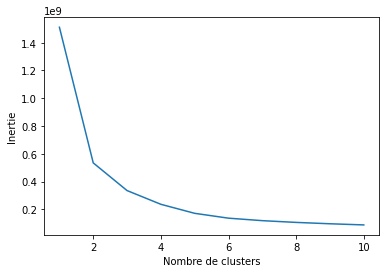

In [12]:
# Est-il pertinent de choisir 5 clusters ?
#inertie = []
#for k in range(1,11):
    #model = KMeans(n_clusters=k).fit(X_kmeans)
    #inertie.append(model.inertia_)

#plt.plot(range(1,11),inertie)
#plt.xlabel('Nombre de clusters')
#plt.ylabel('Inertie')

**Analyse:**<br/>
D'après la méthode du coude, il semble pertinent de choisir 5 clusters. En effet, on constate que pour 5 clusters, l'inertie de ces derniers est assez faible.

In [13]:
# 5 clusters 
model = KMeans(n_clusters=5)
model.fit(X_kmeans)
prediction = model.predict(X_kmeans)

In [14]:
# Le tableau initial 'préparé' contenant la colonne 'nutrition_grade_fr'
cluster_df = X

In [16]:
# On ajoute la colonne qui contient les clusters
cluster_df['clusters'] = prediction

**Affichage:**<br/>
On affiche la distribution de sucre pour 100g en distinguant sur le premier graphique la manière dont se divisent les différents clusters sur cette distribution et sur le deuxième graphique, la manière dont se divisent les différents nutriscores sur la distribution de sucre. On pourra ainsi mettre en évidence la potentielle correspondance entre certains clusters et certains nutriscores.

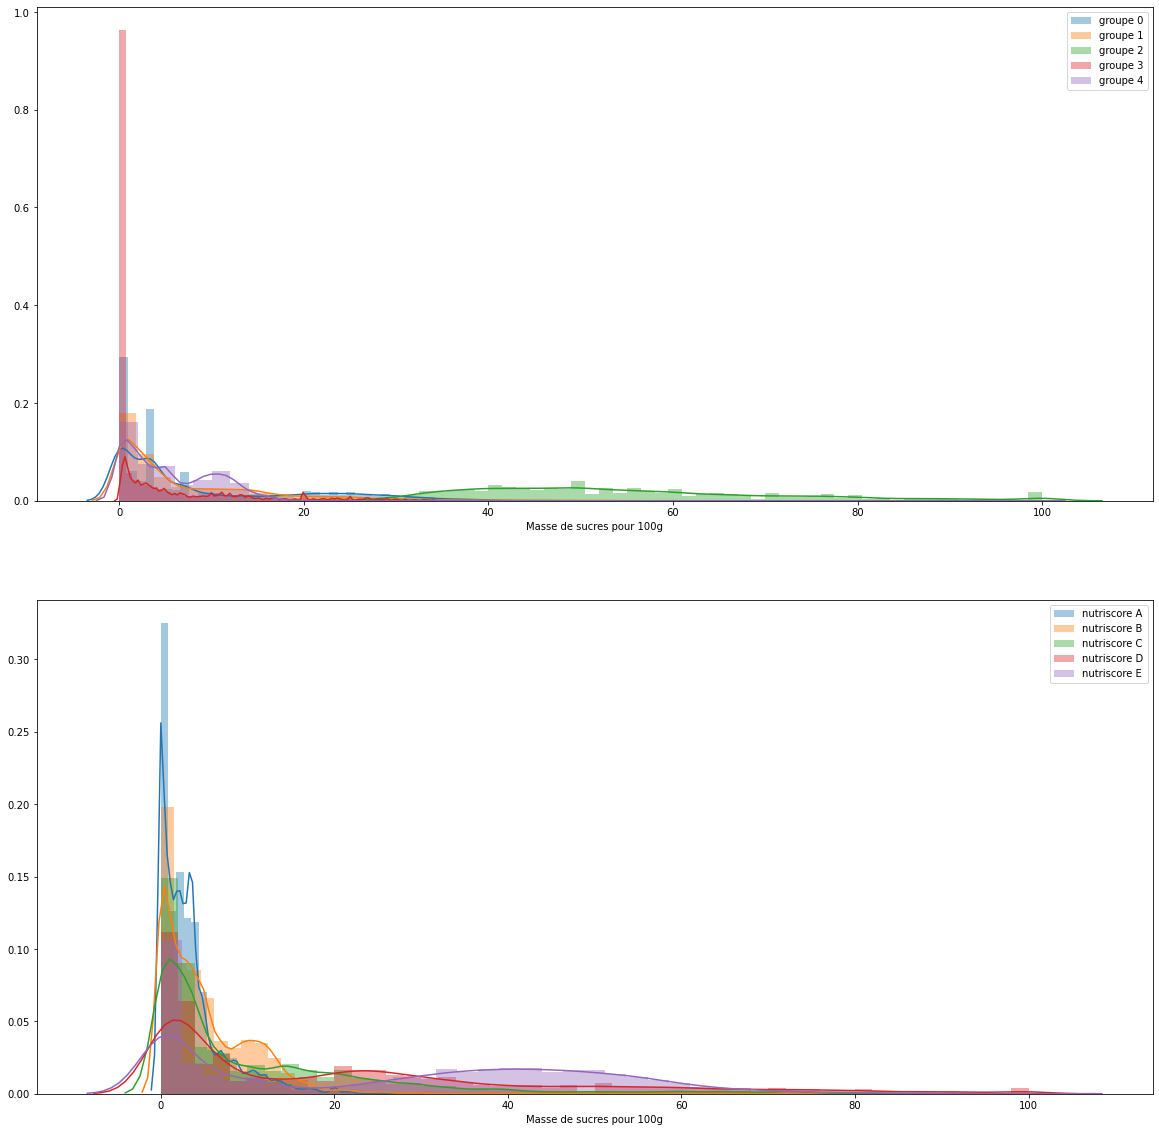

In [17]:
plt.figure(figsize=(20,20))

# Clusters
plt.subplot(2,1,1)
for i in range(0,5):
    sns.distplot(cluster_df['sugars_100g'][cluster_df.clusters == i], label='groupe '+ str(i))
    plt.xlabel('Masse de sucres pour 100g')
    plt.legend()
    
# Nutriscores
plt.subplot(2,1,2)
sns.distplot(df['sugars_100g'][df.nutrition_grade_fr == 0], label='nutriscore A')
sns.distplot(df['sugars_100g'][df.nutrition_grade_fr == 1], label='nutriscore B')
sns.distplot(df['sugars_100g'][df.nutrition_grade_fr == 2], label='nutriscore C')
sns.distplot(df['sugars_100g'][df.nutrition_grade_fr == 3], label='nutriscore D')
sns.distplot(df['sugars_100g'][df.nutrition_grade_fr == 4], label='nutriscore E')
plt.xlabel('Masse de sucres pour 100g')
plt.legend()

**Analyse:**<br/>
La répartition des couleurs est semblable sur les deux graphiques, on peut distinguer les potentiels couples "nutriscore/cluster".
- A - 3
- B - 4
- C - 1
- D - 0
- E - 2

In [18]:
# Associations hypothétiques des clusters et nutriscores
couples = [(0,3,'A'),(1,4,'B'),(2,1,'C'),(3,0,'D'),(4,2,'E')]

**Affichage:**<br/>
L'affichage suivant permet de comparer les distributions de sucre de chaque couple "nutriscore/cluster". Cela permet d'avoir une idée plus claire sur la pertinence des couples établis.

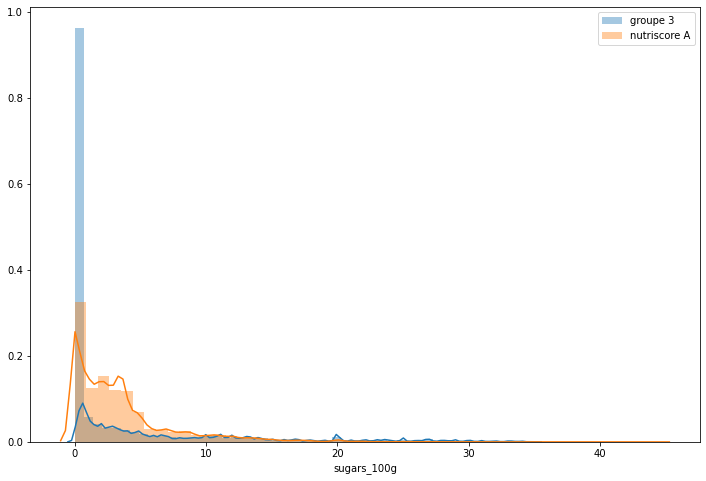

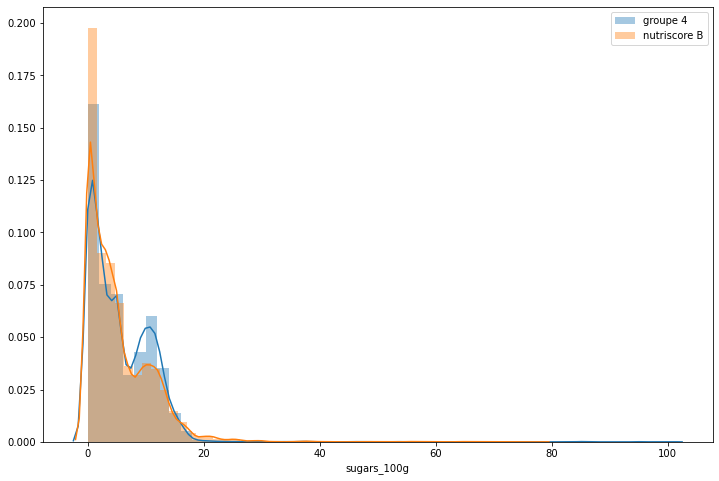

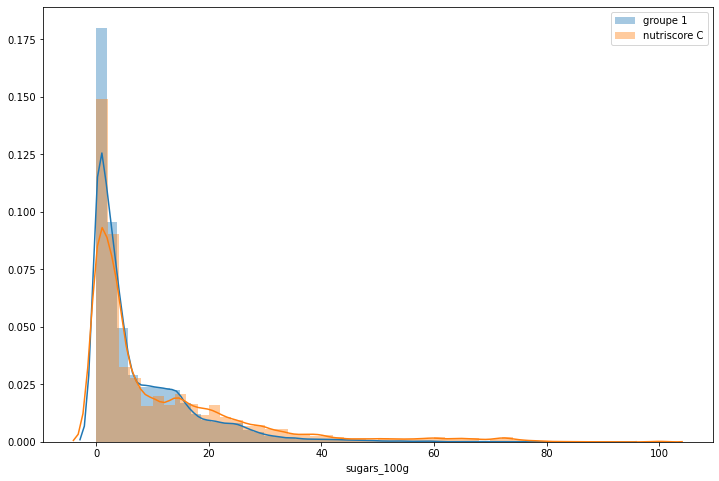

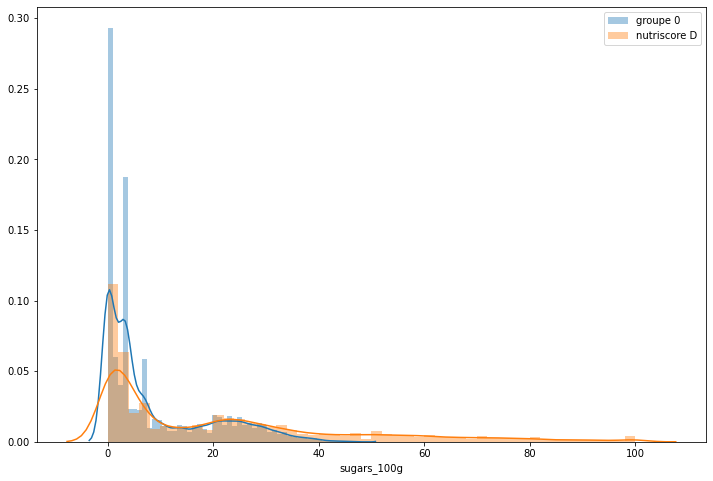

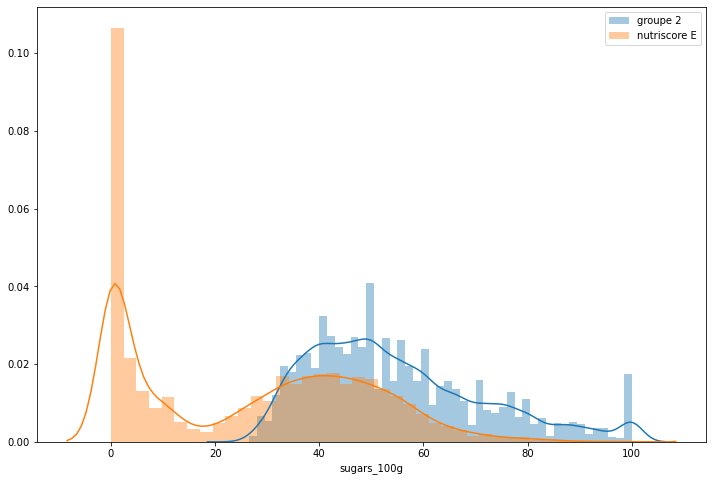

In [19]:
# Comparer la distribution de 'fat' pour chaque nutriscore avec le potentiel cluster associé
for i,j,n in couples:
    plt.figure(figsize=(12,8))
    sns.distplot(cluster_df['sugars_100g'][cluster_df.clusters == j], label='groupe '+ str(j))
    sns.distplot(df['sugars_100g'][df.nutrition_grade_fr == i], label='nutriscore '+ n)
    plt.legend()

**Analyse:**<br/>
Les distributions correspondent assez bien. Afin de quantifier cette correspondance, nous allons afficher le pourcentage d'aliments pour lesquels le cluster correspond au nutriscore (à partir des couples établis).

In [21]:
# Association du nutriscore à son potentiel homologue cluster
cluster_df['clusters'].replace([3,4,1,0,2],[0,1,2,3,4], inplace=True)

In [22]:
# Pourcentage de correspondance entre les clusters et les nutriscores
((cluster_df.loc[cluster_df['clusters']==cluster_df['nutrition_grade_fr'],:].shape[0])/(cluster_df.shape[0]))*100

46.873499878346294

**Analyse du pourcentage de correspondance:**<br/>
47% des produits ont un cluster qui correspond à son nutriscore associé c'est-à-dire: **A ~ cluster3, B ~ cluster4, C ~ cluster1, D ~ cluster0** et **E ~ cluster2**. On comprend donc que le nutriscore a été dominant dans la manière d'établir les clusters. On peut alors de demander pourquoi le nutriscore a-t-il été prépondérant dans la manière d'établir les clusters ? Comme nous l'avons constaté grâce à l'acp, le nutriscore est ce qui résume le mieux le jeu de données tel qu'il est fourni. Le premier axe principal de projection pouvait être associé au nutriscore parce que le nutriscore y était fortement corrélé mais aussi parce que toutes les variables que le nutriscore prend en compte y étaient églement fortement corrélées. Ceci explique que le clustering ait été fait à 47% en fonction du nutriscore. 

In [23]:
# Tableau des coordonnées des centroïdes
centroides_df = pd.DataFrame(model.cluster_centers_, columns=X_kmeans.columns)

---
**Enregistrement des variables relatives au clustering n°1**

In [40]:
import pickle

with open("transfer_centroides_df","wb") as fichier:
    centroides_df_pickler=pickle.Pickler(fichier)
    centroides_df_pickler.dump(centroides_df)
    

with open("transfer_prediction","wb") as fichier:
    prediction_pickler=pickle.Pickler(fichier)
    prediction_pickler.dump(prediction)
    

**Fin d'enregistrement des variables relatives au clustering**

---

### Centroïdes des nutriscores

**Objectif:**<br/>
L'objectif est de comparer les positions des centroïdes sur les axes correpondant aux variables principales de notre tableau. On va comparer les positions des centroïdes du clustering que nous venons d'effectuer avec la position des centroîdes des nutriscores. Pour obtenir les centroïdes de chaque nutriscore, on va distinguer 5 tableaux, un pour chaque nutriscore, puis on va effectuer un KMean clustering à n = 1 cluster sur chaque tableau.

In [41]:
# Un nutriscore = Un tableau sur lequel on fera un kmeans avec n = 1 cluster

nutriscore_A = X.loc[ X['nutrition_grade_fr'] == 0, :]
nutriscore_B = X.loc[ X['nutrition_grade_fr'] == 1, :]
nutriscore_C = X.loc[ X['nutrition_grade_fr'] == 2, :]
nutriscore_D = X.loc[ X['nutrition_grade_fr'] == 3, :]
nutriscore_E = X.loc[ X['nutrition_grade_fr'] == 4, :]

In [43]:
# Un kmeans sur chaque tableau avec n_cluster = 1

# 1 cluster = 1 centroïde pour nutriscore A
model_A = KMeans(n_clusters=1)
model_A.fit(nutriscore_A)
centroides_A = model_A.cluster_centers_

# 1 cluster = 1 centroïde pour nutriscore B
model_B = KMeans(n_clusters=1)
model_B.fit(nutriscore_B)
centroides_B = model_B.cluster_centers_

# 1 cluster = 1 centroïde pour nutriscore C
model_C = KMeans(n_clusters=1)
model_C.fit(nutriscore_C)
centroides_C = model_C.cluster_centers_

# 1 cluster = 1 centroïde pour nutriscore D
model_D = KMeans(n_clusters=1)
model_D.fit(nutriscore_D)
centroides_D = model_D.cluster_centers_

# 1 cluster = 1 centroïde pour nutriscore E
model_E = KMeans(n_clusters=1)
model_E.fit(nutriscore_E)
centroides_E = model_E.cluster_centers_

In [48]:
# Concaténation de chaque ligne correspondante à un centroïde

centroides_nutriscore_tab = np.concatenate((centroides_A,
                                           centroides_B,
                                           centroides_C,
                                           centroides_D,
                                           centroides_E),
                                          axis=0)

(5, 15)

In [49]:
# Création du dataframe contenant les coordonnées des centroïdes
centroides_nutriscore_df = pd.DataFrame(centroides_nutriscore_tab,
                                        columns=X.columns)

,fat_100g,cholesterol_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,additives_n,ingredients_from_palm_oil_n,nutrition_grade_fr,serving_size,clusters
0,3.142838,0.002508,5.280834,0.717040,2.924443,0.065979,0.000076,0.004951,0.012234,0.000984,0.910652,0.004092,0.0,36.074856,0.871717
1,3.456844,0.004784,5.199179,1.088081,4.935306,0.200183,0.000063,0.004992,0.032810,0.000569,1.484555,0.002843,1.0,96.136827,1.349504
2,9.077331,0.006922,10.904196,1.715768,6.769284,0.311800,0.000052,0.003180,0.037972,0.001295,1.676231,0.008294,2.0,55.176696,1.879158
3,16.269414,0.010830,21.440669,1.375411,8.205426,0.346679,0.000037,0.001926,0.036871,0.001176,2.147045,0.011895,3.0,35.046434,2.428508
4,24.128608,0.014139,29.747427,1.210116,7.007394,0.312725,0.000032,0.000519,0.037537,0.000893,1.932390,0.014298,4.0,29.323773,2.893063


**Affichage:**<br/>
<ul><li>En abscisse il y a les variables principales (sucre, lipide, sel, et serving-size). Chaque point coloré correspond à un nutriscore ou à un cluster sachant qu'on a coloré chaque cluster de la même manière que son nutriscore associé.</li>
    <li>Verticalement, on compare (grâce aux axes des abscisses partagés) les nutriscores avec leur homologue cluster.</li>
    <li>Ce graphique peut être analysé de deux manières. La première est de comparer les distances entre les clusters eux-mêmes ou entre les nutriscores eux-mêmes. La deuxième est de comparer les écarts entre les nutriscores et leurs clusters associés.</li></ul>

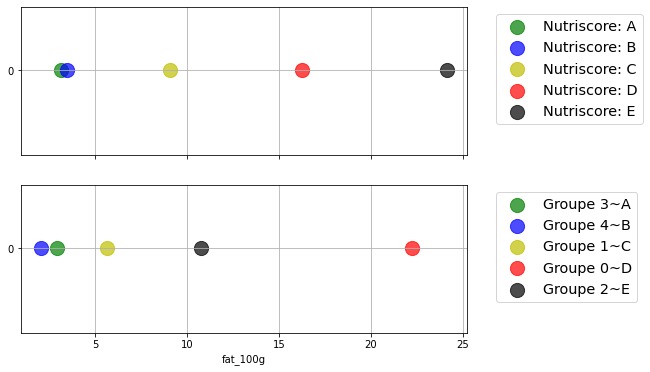

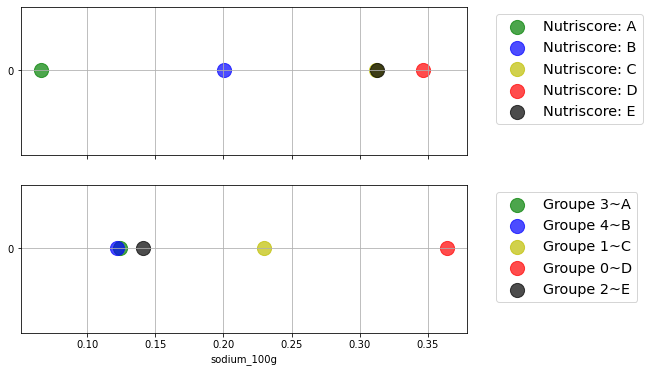

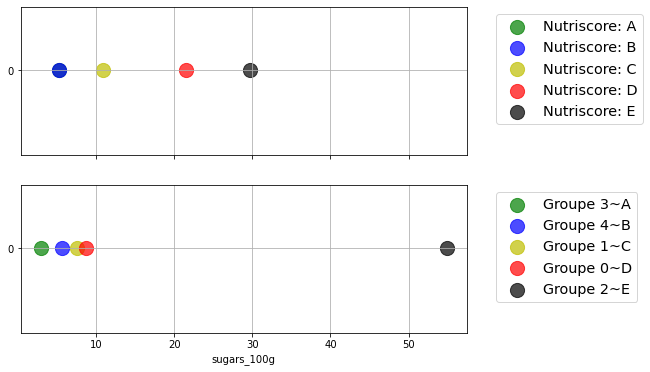

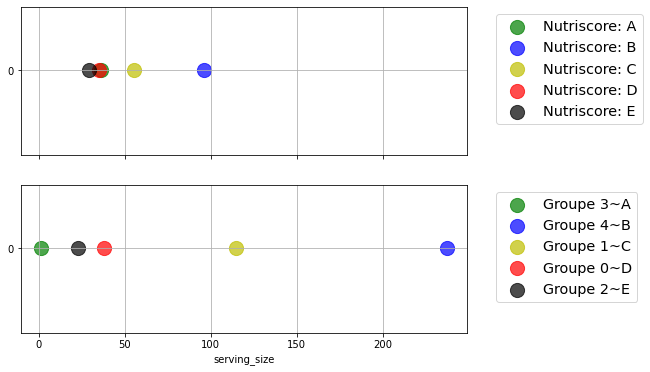

In [90]:
# Affichage des centroïdes sur les axes correspondants aux variables principales

color_dict = [(0,'g','A',3),
              (1,'b','B',4),
              (2,'y','C',1),
              (3,'r','D',0),
              (4,'k','E',2)]

for col in ['fat_100g','sodium_100g','sugars_100g','serving_size']:
    fig, ax = plt.subplots(2,1,sharex=True, figsize=(8,6))
    for i1, color, n, i2 in color_dict:
        
        ax[0].scatter(centroides_nutriscore_df.loc[i1,col], 
                    np.zeros_like(centroides_nutriscore_df.loc[i1,col]), 
                    c=color, 
                    alpha=0.7,
                    label='Nutriscore: '+n,
                    s=200)
        ax[0].legend(loc='upper left', bbox_to_anchor=(1.05,1), fontsize='x-large')
        ax[0].margins(y=3)
        ax[0].set_yticks([0])
        ax[0].grid()
        

        ax[1].scatter(centroides_df.loc[i2,col], 
                    np.zeros_like(centroides_df.loc[i2,col]), 
                    c=color, 
                    alpha=0.7, 
                    label='Groupe ' + str(i2) + '~' + n, # cluster ~ nutriscore équivalent
                    s=200)
        ax[1].margins(y=3)
        ax[1].set_xlabel(col)
        ax[1].legend(loc='upper left', bbox_to_anchor=(1.05,1), fontsize='x-large')
        ax[1].set_yticks([0])
        ax[1].grid()
  


**Première analyse: Les nutriscores entre eux.**<br/>
Si on ne prend pas en compte la variable serving-size, les autres graphiques permettent de comprendre comment sont établis les nutriscores:
<ul><li>pour les lipides, on voit qu'il n'y a presque pas de différence entre le nutriscore A et le nutriscore B mais qu'ensuite, entre les nutriscores C, D et E les distances sont constantes,</li>
    <li>pour le sel, il y a un grand écart entre le nutriscore A et le nutriscore B mais le point noir et le point jaune sont confondus (très difficile à voir sur le graphique mais on distingue un halo jaune très léger autour de la pastille noire) ce qui signifie que les nutriscores C, E et D (point rouge) sont établis à partir d'une quantité de sel semblable,</li>
    <li>pour le sucre, le nutriscore A et le nutriscore B sont confondus puis les écarts entre les nutriscores sont presque constants.</li></ul>
Comment cette analyse peut-elle servir concrètement ? La réponse est que l'on peut <strong>choisir le nutriscore en fonction des caractéristiques qui nous intéressent</strong>. Par exemple, si on désire réduire sa consommation de sucre, plutôt que de ne manger que des aliments ayant un nutriscore A, on sait maintenant qu'on pourra indifféremment manger des produits ayant un nutriscore A ou B.

**Deuxième analyse: Comparaison des clusters et des nutriscores.**<br/>
<ul><li>On constate d'abord qu'il y a toujours au moins deux centroïdes de clusters qui ont des positions sur l'axe presque égales celles de leur homologue nutriscore. Par exemple pour la variable fat_100g, les points bleu et vert ont des positions semblables sur le graphique des nutriscores et sur celui des clusters.</li>
    <li>On constate également que les clusters s'étalent plus sur l'axe que les nutriscores et que leurs distances sont moins homogènes.</li></ul>

**Cas particulier de la variable serving-size.**<br/>
Cette variable est un cas particulier car elle n'est pas prise en compte dans l'élaboration du nutriscore. Il semblerait que plus le nutriscore est mauvais plus la portion recommandée est petite (ce que nous avions déjà constaté lors de l'acp). Ainsi, bien que cette variable ne soit pas prise en compte lors de l'élaboration du nutriscore, le nutriscore donne  quand même une information sur cette dernière. **On peut alors se demander s'il n'y a pas des paramètres importants à prendre en compte que le nutriscore ne peut pas couvrir ? En effet, si un cluster correspondait à un nutriscore, ne serait-il pas possible de mettre en évidence une nouvelle notation à partir des données du tableau ?** C'est la question à laquelle nous tenterons de répondre dans la partie III.

**Remarque importante concernant les graphiques de serving-size.**<br/>
On constate que le point vert a des portions recommandées très faibles alors que c'est le meilleur nutriscore... pourquoi ? C'est en fait une conséquence de notre système d'imputation. On a imputé des 0 là où il y avait des valeurs manquantes or, les produits ayant un nutriscore A sont des produits où il manque beaucoup de valeurs. D'ailleurs, **tous** ces produits possèdent au moins une valeur manquante dans une quelconque variable. Etant donné que ces produits sont recommandés, il est logique qu'il n'y ait pas de "portion idéale" pour une grande partie d'entre eux qui peuvent presque être consommés sans modération. En imputant des 0 on a donc déplacé les coordonnées du centroïde de ce nutriscore.

---
**Enregistrement des coordonnées des centroides des nutriscores**

In [92]:
import pickle

with open("transfer_centroides_nutriscore_df","wb") as fichier:
    centroides_nutriscore_df_pickler=pickle.Pickler(fichier)
    centroides_nutriscore_df_pickler.dump(centroides_nutriscore_df)
    
with open("transfer_X","wb") as fichier:
    X_pickler=pickle.Pickler(fichier)
    X_pickler.dump(X)

**Fin enregistrement**

---

### Conclusion de la partie II

On a maintenant une idée claire sur la manière dont est établi le nutriscore. On sait que c'est un très bonne indicateur en ce qui concerne le sel, le sucre et les lipides des aliments. Autrement dit, si on veut manger des produits moins salés, on sait qu'en choisissant des aliments qui ont de bons nutriscores on réduira sa consommation de sel. On pourrait alors se dire: "Je veux limiter ma consommation de sel donc je vais me limiter aux produits ayant des nutriscores A ou B.". Cependant, on a constaté (graphiques de comparaison entre clusters et nutriscores) qu'entre le nutriscore A et B les quantités de sel sont très différentes. Ainsi, on développe notre regard critique concernant le nutriscore et on se dit: "Je sais que les produits ayant un nutriscore B sont vraiment plus salés que les produits ayant un nutriscore A mais ils conservent des quantités convenables de sel contrairement à ceux ayant les nutriscores C, D et E. Bien que je veuille réduire ma consommation de sel, je ne veux pas la réduire à néant donc je conserve les produits ayant un nutriscore B. Ah oui, et j'ai entendu parler des additifs alimentaires et de leurs potentiels effets nocifs dont je veux absolument prémunir ma famille et moi mais je n'y connais rien du tout et le nutriscore ne me sera d'aucune aide...". C'est le problème que nous allons tenter de résoudre dans la troisième partie de ce notebook.

# III. Un autre système d'évaluation.

---
**Récupération des données**

In [38]:
import pickle

with open("transfer_df","rb") as fichier:
    df_depickler=pickle.Unpickler(fichier)
    df=df_depickler.load()
    
with open("transfer_data","rb") as fichier:
    data_depickler=pickle.Unpickler(fichier)
    data=data_depickler.load()
    
    
with open("transfer_additifs_df","rb") as fichier:
    additifs_df_depickler=pickle.Unpickler(fichier)
    additifs_df=additifs_df_depickler.load()
    

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import exploration as ex
import numpy as np
import seaborn as sns

**Fin récupération des données**

---

In [39]:
df_new = df.copy()

In [40]:
# Suppression des variables ayant plus de 90% de valeurs manquantes
for col in df_new.columns:
    if (df_new[col].isna().sum()/df_new.shape[0])*100 >= 90:
        df_new.drop(col,axis=1,inplace=True)

## III. A. Ce que le tableau nous murmure.

On a vu qu'il y avait deux catégories de variables dans le tableau: celles qui sont prises en compte par le nutriscore et celles qui ne sont pas prises en compte par le nutriscore. Jusqu'ici, nous n'avons étudié que celles qui sont prises en compte par le nutriscore à l'exception de serving-size. Un problème se pose lorsqu'il s'agit d'étudier ce que le nutriscore ne prend pas en compte: la forme des variables. En effet, il y a beaucoup d'informations dans la liste des ingrédients qui est une variable textuelle. On va donc devoir extraire les informations importantes de cette variable ainsi que de la variable additives_tags afin d'établir de nouvelles colonnes. Dans cette partie, les variables que nous allons tenter d'extraire sont:
<ul><li>les additifs nocifs présents dans un aliment,</li>
    <li>la présence ou non de sucre ajouté dans un aliment.</li></ul>
Ces deux variables correspondent à ce que le tableau ne nous dit pas explicitement mais plutôt à ce qu'il nous murmure.

### Le sucre ajouté.

**Affichage suivant:**<br/>
Commençons par la variable ingrédients_text. On affiche les 20 ingrédients les plus présents dans le jeu de données.

In [42]:
ingredients=ex.most_common_words(df_new['ingredients_text'].values,nombre_de_mots=20)
ingredients

[('de', 261818),
 ('salt,', 99242),
 ('and', 75723),
 ('sugar,', 74190),
 ('nan', 71786),
 (':', 63795),
 ('water,', 62780),
 ('natural', 62507),
 ('oil,', 62388),
 ('organic', 60963),
 ('corn', 59575),
 ('flour,', 50562),
 ('sodium', 49945),
 ('acid,', 42973),
 ('syrup,', 41243),
 ('milk,', 38322),
 ('citric', 36925),
 ('wheat', 32975),
 ('soy', 30540),
 ('starch,', 30169)]

In [43]:
# Les mots qui indiquent que du sucre a été ajouté
CATEGS = { # Variable categorie_sucre
    'sugar,': 1,
    'syrup,': 1,
    'sugar': 1,
    'corn syrup': 1,
}

In [44]:
# Assignation des aliments a une categorie: sucre ajouté ou pas.
def detect_words(values, dictionary):
    result = []
    for text in values:
        text=str(text)
        type_produit = 0
        for word, val in dictionary.items():
            if word in text:
                type_produit = val
        result.append(type_produit)
    return result

In [45]:
# Création de la variable "sucre_ajouté"
df_new["sucre_ajoute"] = detect_words(df_new["ingredients_text"].values, CATEGS)

In [46]:
# Pourcentage d'aliments contenant du sucre ajouté dans le jeu de données
print("Pourcentage d'aliments contenant du sucre ajouté dans le jeu de données: {} %.".format(round(100*df_new.sucre_ajoute.mean(),1)))

Pourcentage d'aliments contenant du sucre ajouté dans le jeu de données: 27.2 %.


**27% de produits contenant du sucre ajouté (parmi les valeurs renseignées):**<br/>
Cette valeur nous donne une idée de la tendance des valeurs de notre jeu de données à avoir du sucre ajouté ou pas. Il faudra, dans la suite de l'analyse, comme nous l'avons vu, également prendre en compte les additifs.

In [47]:
# Pour la suite de l'analyse on impute des 0 là où il y a des Nan.
df_new.sucre_ajoute = df_new.sucre_ajoute.fillna(0)

### Additifs nocifs.

**Démarche pour identifier les additifs_nocifs:**<br/>
Nous avons récupéré le tableau des additifs nocifs (ou peu recommandés) présent à l'adresse suivante: <br/>
https://www.quechoisir.org/comparatif-additifs-alimentaires-n56877/?f4%5B%5D=EQpicto-3-orange.png&f4%5B%5D=EQpicto-4-rouge.png#filtres .<br/>
Nous allons créer une variable additifs_nocifs dans laquelle figureront des "0" lorque le produit ne contiendra pas d'additif nocifs et des '1' lorqu'il y aura au moins un additif nocif dans le produit. 

In [48]:
# Les additifs nocifs
DANGER = {val:1 for val in additifs_df['Produit'].values}
DANGER

{'e102': 1,
 'e104': 1,
 'e110': 1,
 'e120': 1,
 'e122': 1,
 'e123': 1,
 'e124': 1,
 'e129': 1,
 'e131': 1,
 'e150': 1,
 'e171': 1,
 'e173': 1,
 'e210': 1,
 'e211': 1,
 'e212': 1,
 'e213': 1,
 'e249': 1,
 'e250': 1,
 'e251': 1,
 'e252': 1,
 'e284': 1,
 'e285': 1,
 'e319': 1,
 'e320': 1,
 'e338': 1,
 'e339': 1,
 'e340': 1,
 'e341': 1,
 'e343': 1,
 'e432': 1,
 'e433': 1,
 'e434': 1,
 'e435': 1,
 'e436': 1,
 'e442': 1,
 'e450': 1,
 'e451': 1,
 'e452': 1,
 'e466': 1,
 'e468': 1,
 'e469': 1,
 'e471': 1,
 'e472a': 1,
 'e472b': 1,
 'e472c': 1,
 'e472d': 1,
 'e472e': 1,
 'e472f': 1,
 'e473': 1,
 'e474': 1,
 'e475': 1,
 'e476': 1,
 'e477': 1,
 'e479': 1,
 'e481': 1,
 'e482': 1,
 'e491': 1,
 'e492': 1,
 'e493': 1,
 'e494': 1,
 'e495': 1,
 'e520': 1,
 'e521': 1,
 'e522': 1,
 'e523': 1,
 'e541': 1,
 'e551': 1,
 'e552': 1,
 'e553': 1,
 'e554': 1,
 'e555': 1,
 'e620': 1,
 'e621': 1,
 'e622': 1,
 'e623': 1,
 'e624': 1,
 'e625': 1,
 'e950': 1,
 'e951': 1,
 'e952': 1,
 'e954': 1,
 'e955': 1,
 'e962': 1

In [49]:
# Création de la variable "additifs_nocifs"
df_new["additifs_nocifs"] = detect_words(df_new["additives_tags"].values, DANGER)

In [50]:
# Pourcentage d'aliments contenant un ou plusieurs additifs nocifs
print("Pourcentage d'aliments contenant un ou plusieurs additifs nocifs: {} %.".format(round(100*df_new.additifs_nocifs.mean(),1)))

Pourcentage d'aliments contenant un ou plusieurs additifs nocifs: 21.6 %.


In [51]:
ex.missing_frame(df_new,get_row=True,row_name='additives_tags')

,nom_colonne,nbr_val_manquantes,facteur_remplissage
10,additives_tags,165701,48.242699


**Que nous apprennent ces résultats ?**<br/>
Premièrement, 1 produit sur 2 de notre jeu de données contient au moins un additif si on considère que là où il n'y a rien de renseigné il n'y a pas d'additif. Deuxièmement, 22% des produits contenant des additifs contiennent des additifs très dangereux à éviter absolument ou des additifs qui ne sont pas recommandés ce qui représente 35800 aliments... 

Maintenant qu'on a extrait les informations utiles des variables 'ingredients_text' et 'additives_tags' on peut les supprimer

In [52]:
df_new = df_new.drop(['additives_tags','ingredients_text'], axis=1)

### Sucre ajouté, additifs nocifs et leurs corrélations

**Affichage n°1:**<br/>
On affiche la matrice des corrélations des 3 variables les corrélées à **sucre_ajoute**.

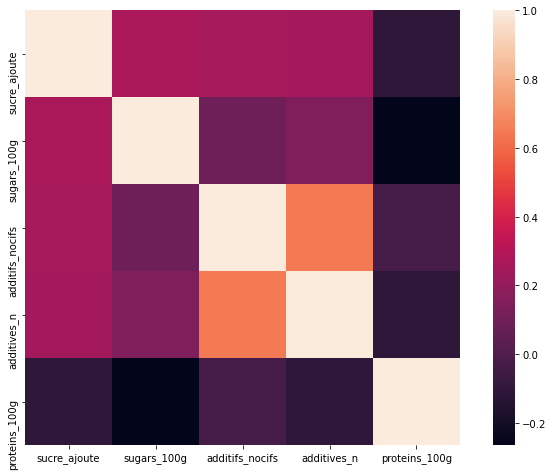

In [53]:
# Corrélations de df_new
corr_matrix = df_new.corr()

# On choisit 3 variables les plus corrélées à 'sucre_ajoute'
k1 = 4

# On choisit la variable la plus anticorrélée à 'sucre_ajoute'
k2 = 1

# Les variables les plus corrélées et anticorrélées à 'nutrition_grade_fr'
cols1 = corr_matrix.nlargest(k1, 'sucre_ajoute')['sucre_ajoute'].index
cols2 = corr_matrix.nsmallest(k2, 'sucre_ajoute')['sucre_ajoute'].index
cols = list(cols1) + list(cols2)

# Matrice des corrélations les plus fortes
corrmat_nutriscore = df_new[cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corrmat_nutriscore, 
            cbar=True, 
            square=True,
            yticklabels=cols, 
            xticklabels=cols)

**Analyse des corrélations de la variable sucre_ajoute:**<br/>
La variable la plus corrélée à sucre_ajouté est la variable sugars_100g. Autrement dit, plus un produit contient de sucre simple (celui qui donne le goût sucré), plus il sera probable qu'il contienne du sucre ajouté. Pour comprendre ce constat, on peut par exemple donner l'exemple suivant: la banane est sucrée, riche en sucres simples notamment le fructose, mais ne contient pas de sucre ajouté alors qu'une barre chocolatée est également riche en fructose (ou une forme dérivée), mais c'est du fructose qui a été volontairement ajouté pour donner un goût sucré à la barre.

**Affichage n°2:**<br/>
On affiche la matrice des corrélations des 3 variables les corrélées à **additifs_nocifs**.

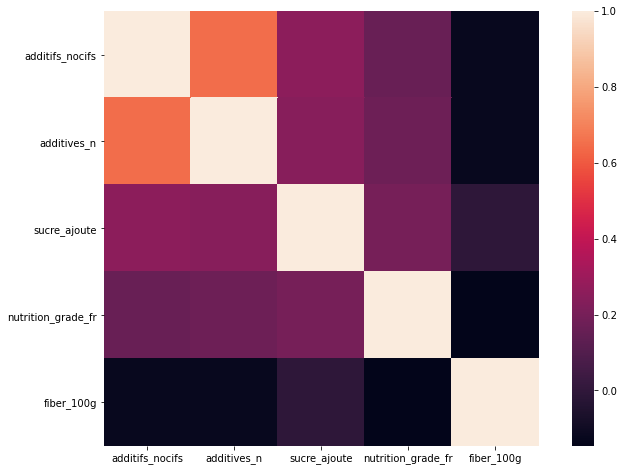

In [54]:
# Corrélations de df_new
corr_matrix = df_new.corr()

# On choisit 3 variables les plus corrélées à 'additifs_nocifs'
k1 = 4

# On choisit la variable la plus anticorrélée à 'additifs_nocifs'
k2 = 1

# Les variables les plus corrélées et anticorrélées à 'nutrition_grade_fr'
cols1 = corr_matrix.nlargest(k1, 'additifs_nocifs')['additifs_nocifs'].index
cols2 = corr_matrix.nsmallest(k2, 'additifs_nocifs')['additifs_nocifs'].index
cols = list(cols1) + list(cols2)

# Matrice des corrélations les plus fortes
corrmat_nutriscore = df_new[cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corrmat_nutriscore, 
            cbar=True, 
            square=True,
            yticklabels=cols, 
            xticklabels=cols)

**Analyse des corrélations de la variable additifs_nocifs:**<br/>
On peut constater que les variables 'additives_n' et 'additifs_nocifs' sont très corrélées. C'est un constat assez intuitif, plus il y a d'additifs dans un produit, plus il y a de chance qu'il contienne au moins un additif nocif. Les autres coefficients de corrélation sont assez faibles mais il intéressant de constater que la deuxième variable la plus corrélée à additifs_nocifs est le sucre_ajouté. Cela indique que les produits contenant des additifs nocifs auraient tendance à contenir aussi du sucre ajouté.

**Nutriscore, additifs et sucre ajouté.**<br/>
Concluons cette partie par une remarque sur le nutriscore. Sur les deux affichages précédents nous avons pu observer les variables les plus corrélées et anticorrélées à 'sucre_ajouté' et à 'additifs_nocifs'. Sur aucune des deux matrices ne figure le nutriscore. Autrement dit, l'étendue du nutriscore (au-delà de ce pour quoi il a été fait) ne semble pas prendre en compte les additifs nocifs et le sucre ajouté des aliments. On pourrait donc avoir un aliment avec un nutriscore A mais contenant un additif nocif.

---
**Enregistrement de df_new**

In [55]:
with open("transfer_df_new","wb") as fichier:
    df_new_pickler=pickle.Pickler(fichier)
    df_new_pickler.dump(df_new)

**Fin enregistrement**

---

## III. B. Tout savoir sur le sucre ajouté et les additifs

**Objectif de cette sous-partie.**<br/>
L'objectif de cette sous-partie est d'étudier les relations entre les variables additifs nocifs, sucre ajouté et les autres variables du tableau. On pourra donc émettre des hypothèses pour ensuite les tester afin de les rejeter ou non.

---
**Récupération de df_new**

In [24]:
import pickle

with open("transfer_df_new","rb") as fichier:
    df_new_depickler=pickle.Unpickler(fichier)
    df_new=df_new_depickler.load()


%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import exploration as ex
import numpy as np
import seaborn as sns

**Fin récupération**

---

### Deuxième analyse en composantes principales

In [25]:
# Copie qui nous servira pour l'acp
data_acp2 = df_new.copy()

In [28]:
# Suppression des variables qualitatives
for col in data_acp2.columns:
    if data_acp2[col].dtypes == 'object':
        data_acp2.drop(col,axis=1,inplace=True)

**Traitement des valeurs manquantes:**<br/>
<ul><li>Pour la variable 'additives_n' on impute des 0 qui est la classe modale de cette variable.</li>
    <li>Partout ailleur on impute par la moyenne.</li></ul>

In [31]:
# Imputation de 0 pour la variable additives_n
data_acp2.additives_n.fillna(0, inplace=True)

# Imputation par la moyenne partout ailleurs
data_acp2 = data_acp2.fillna(data_acp2.mean())

In [33]:
# Il y aura donc au maximum 15 composantes
n_comp = 15

In [34]:
# Conversion des données en array
X_acp2 = data_acp2.values

In [35]:
# Sauvegarde des colonnes de data_acp
features = data_acp2.columns

**Variables illustratives:**<br/>
Dans le cadre de notre objectif on va distinguer 2 variables illustratives pour l'ACP:
<ul><li>le taux de sucre: très sucré, modérément sucré, peu sucré et pas sucré</li>
    <li>le taux de gras: très gras, modérément gras, pas très gras et sans matière grasse</li></ul>
Ces deux variables permettront de colorer les projections sur les plans factoriels ce qui fournira dans un premier temps, une bonne base d'analyse.

In [36]:
# Récupération de sugar_disc et de fat_disc

with open("transfer_sugar_disc","rb") as fichier:
    sugar_disc_depickler=pickle.Unpickler(fichier)
    sugar_disc=sugar_disc_depickler.load()

with open("transfer_fat_disc","rb") as fichier:
    fat_disc_depickler=pickle.Unpickler(fichier)
    fat_disc=fat_disc_depickler.load()

In [37]:
# Variables illustratives
sugar = [sugar_disc[ind] for ind in sugar_disc.index ]
fat = [fat_disc[ind] for ind in fat_disc.index ] 

In [38]:
from sklearn import decomposition
from sklearn import preprocessing

In [39]:
# Centrage et réduction des données
X_acp2_scaled = preprocessing.StandardScaler().fit_transform(X_acp2)

In [40]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_acp2_scaled)

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [41]:
from functions import *

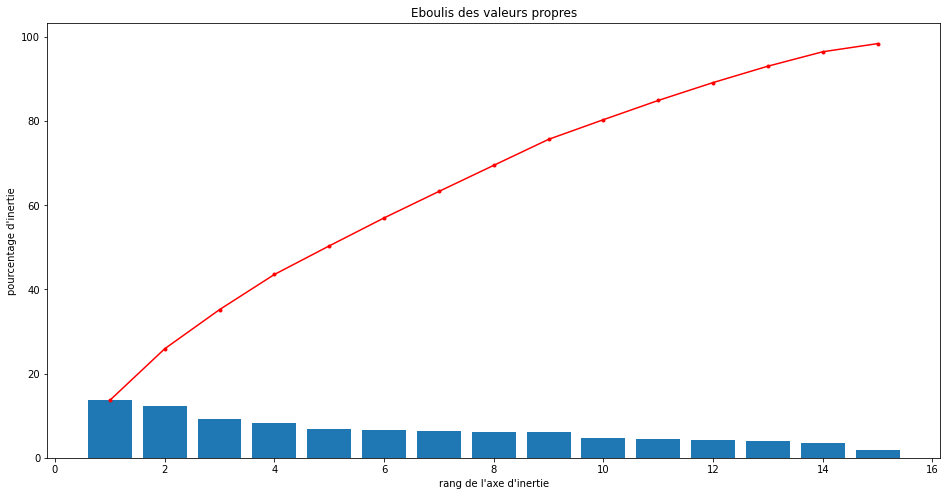

In [42]:
# Eboulis des valeurs propres
display_scree_plot(pca, freq_cumulee=True)

**Choix du nombre de composantes:**<br/>
On choisit de ne représenter que le premier plan factoriel car les autres axes ne représentent que très peu de variabilité.

In [43]:
# Récupération des composantes dans la variable pcs
pcs = pca.components_

# Coordonnées des individus projetés
X_acp2_projected = pca.transform(X_acp2_scaled)

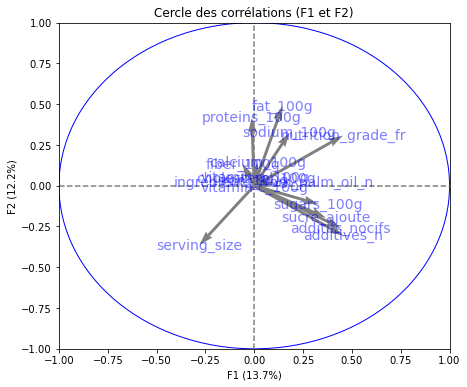

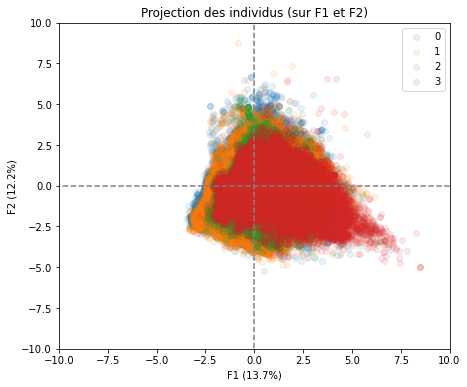

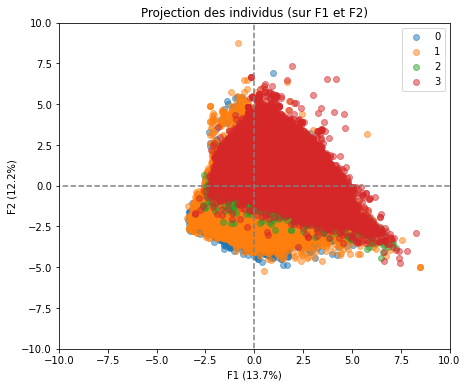

In [47]:
# Cercle F1/F2 des corrélations
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))


# Projection des individus sur F1/F2  SUCRE ZOOM
display_factorial_planes(X_acp2_projected, n_comp, pca, [(0,1)] ,illustrative_var = sugar, alpha=0.1, lims=(-10,10,-10,10))


# Projection des individus sur F1/F2 GRAS ZOOM
display_factorial_planes(X_acp2_projected, n_comp, pca, [(0,1)] ,illustrative_var = fat, alpha=0.5,  lims=(-10,10,-10,10))

**Description du premier plan factoriel F1/F2:**<br/>
Sur le cercle des corrélations il est difficile d'interpréter le premier axe principal de projection car aucune variable ne lui est très corrélée. En ce qui concerne la deuxième composante principale (F2), la variable la plus corrélée à cette dernière est protein_100g et les variables qui lui sont le plus anticorrélées sont additifs_nocifs, additifs_n et sucre_ajoute bien que ces variables ne soient pas très proche de l'axe. On dégage une tendance, c'est-à-dire que lorsque la teneur en protéines d'un aliment augmente, alors, de manière générale, son nombre d'additifs et les chances qu'il contienne du sucre ajouté ou un additif nocif diminuent également. <a href=#cracking>Pourquoi lorsque le taux de protéines augmentent, le nombre d'additifs ainsi que les chances que le produit contienne du sucre ajouté et des additifs nocifs diminuent ?</a>

**Comment se placent les aliments *sugar free*, *low sugar* et *high sugar* dans le premier plan factoriel?**<br/>
Les aliments avec très peu de sucre ont tendance à se répartir sur des abscisses plus faibles que les aliments très sucrés. Bien que la différence (paquet rouge/paquet vert) ne soit pas très marquée elle n'en demeure pas moins remarquable. Cela signifie que les aliments peu sucrés seraient de manière générale moins susceptibles de contenir des additifs nocifs et/ou du sucre ajouté.

**Comment se placent les aliments *fat free*, *low fat* et *high fat* dans le premier plan factoriel?**<br/>
En ce qui concerne les aliments très gras il semblerait qu'une partie d'entre eux s'étale en diagonale dans la même direction que les variables sucre ajouté et additifs nocifs. Cependant, il est difficile de pouvoir de conclure quoique ce soit.

### Analyse des variables sucre ajouté et additifs nocifs

---
**Récupération des données**

In [22]:
import pickle

with open("transfer_df_new","rb") as fichier:
    df_new_depickler=pickle.Unpickler(fichier)
    df_new=df_new_depickler.load()
    
with open("transfer_data","rb") as fichier:
    data_depickler=pickle.Unpickler(fichier)
    data=data_depickler.load()

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import exploration as ex
import numpy as np
import seaborn as sns

**Fin récupération**

---

In [23]:
df_biv = df_new.copy()

In [24]:
cibles = ['sucre_ajoute','additifs_nocifs','nutrition_grade_fr']
variables_continues = ['fat_100g','sodium_100g','sugars_100g','serving_size','proteins_100g']

# Sans sucre ajouté = ssa & Sucre ajouté = sa
ssa_df = df_biv.loc[(df_biv.sucre_ajoute==0),:]
sa_df = df_biv.loc[(df_biv.sucre_ajoute==1),:]

# Sans additifs nocifs = san & Additifs nocifs = an
san_df = df_biv.loc[(df_biv.additifs_nocifs==0),:]
an_df = df_biv.loc[(df_biv.additifs_nocifs==1),:]

**Démarche:**<br/>
On va analyser les graphiques des variables cibles en fonctions des variables principales mais aussi les graphiques des cibles entre elles.

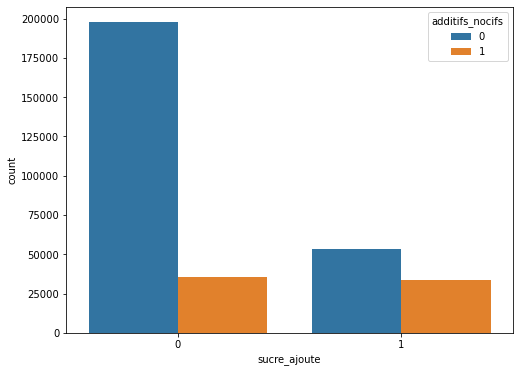

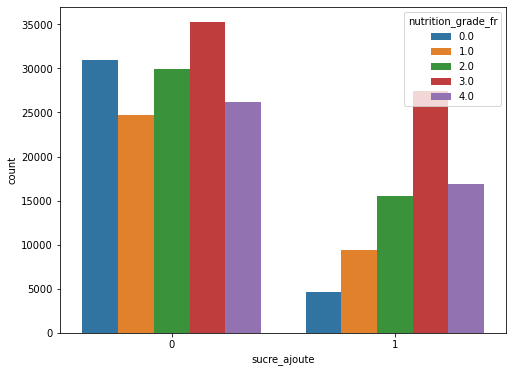

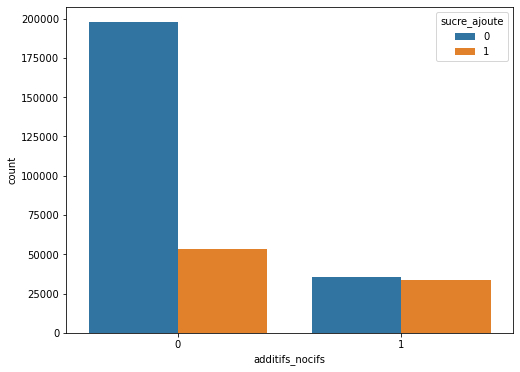

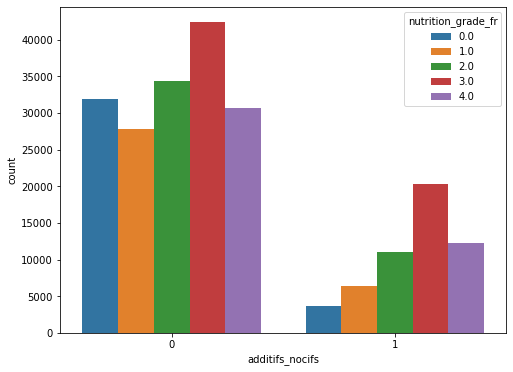

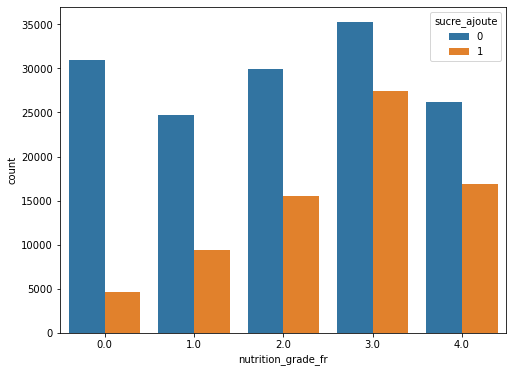

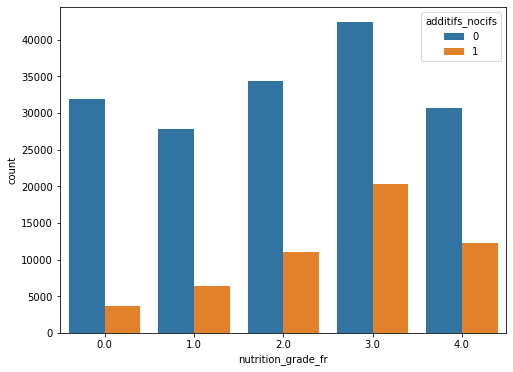

In [25]:
# Cibles entre elles
for i in range(len(cibles)):
    hue_list = (cibles[:i]+cibles[i+1:])
    for col in hue_list:
        plt.figure(figsize=(8,6))
        sns.countplot(x=cibles[i], hue=col, data=df_biv)

**Analyse: cibles entre elles.**<br/>
<ul><li>Pour le sucre ajouté. On constate qu'il y a presque autant de produits qui ont du sucre ajouté et au moins un additif nocif que de produits ayant du sucre ajouté et n'ayant pas d'additif nocif. Etant donné qu'il y a plus de produits ne contenant pas de sucre ajouté, pour avoir une idée claire, il faut étudier les proportions que ces chiffres représentent. Environ 50% des produits ayant du sucre ajouté contiennent des additifs nocifs. Environ 20% des produits n'ayant pas de sucre ajouté contiennent des additifs nocifs. En ce qui concerne le nutriscore, il y a plus de produits avec du sucre ajouté chez les mauvais nutriscores que chez les bons nutriscores. Le nutriscore semble indirectement être un bon indicateur pour le sucre ajouté même s'il y a des produits ayant un nutriscore A et du sucre ajouté.</li>
    <li>Pour les additifs nocifs. Mêmes constats que pour le sucre ajouté. Cependant, bien qu'il y ait plus de produits ayant de mauvais nutriscores et au moins un additif nocif que de produit ayant de bons nutriscores et au moins un additif nocif, on peut dire que dans ce cas là le nutriscore est plus problématique. En effet, un aliment possédant un additif nocif ne peut pas avoir de nutriscore A. On voit ici les limites du nutriscore.</li></ul>

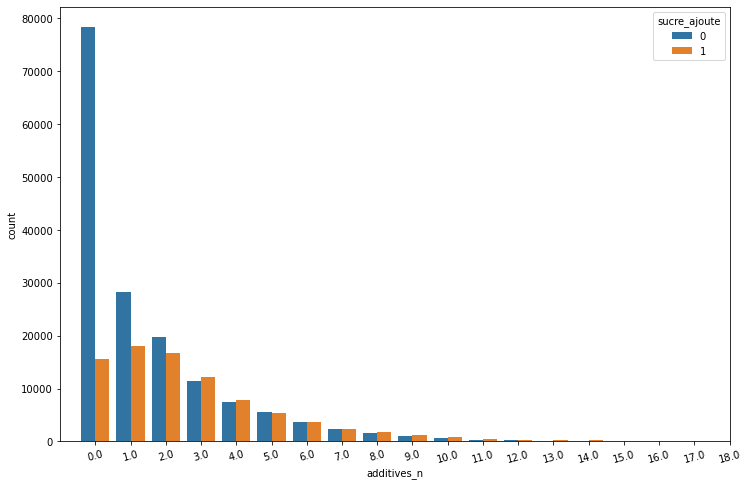

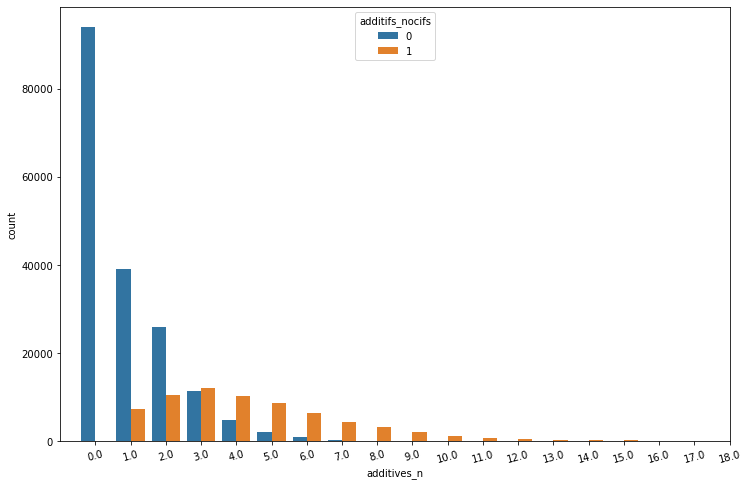

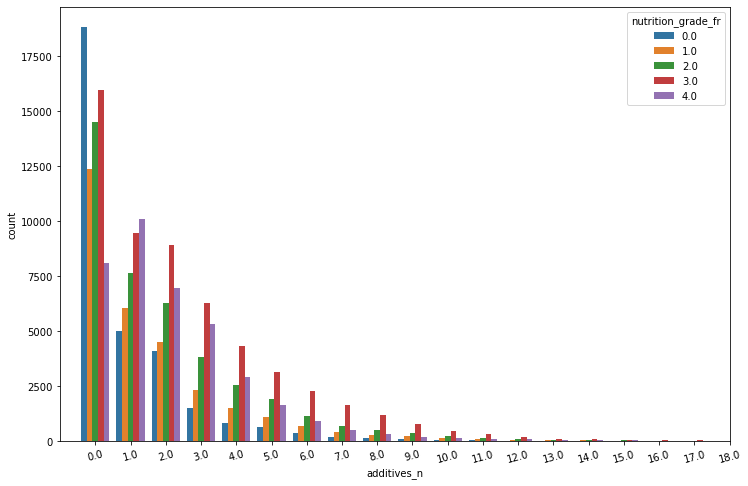

In [26]:
# Cibles et variable discrète ('additives_n')
for cib in cibles:
    plt.figure(figsize=(12,8))
    sns.countplot(x='additives_n',hue=cib,data=df_biv)
    plt.xlim(-1,18)
    plt.xticks(rotation=15)

**Analyse: le nombre d'additifs avec les variables cibles.**<br/>
On constate que plus il y a d'additifs, plus la proportion de produits ayant des additifs nocifs et du sucre ajouté augmente. On constate même, qu'à partir de 3 additifs, il y a plus de produits contenant au moins un additif nocif que de produit n'en contenant pas. En ce qui concerne le nombre d'additifs et le nutriscore, on constate que certains produits possèdent 9 additifs et ont quand même un nutriscore A. Là encore, on atteint les limites du nutriscore.

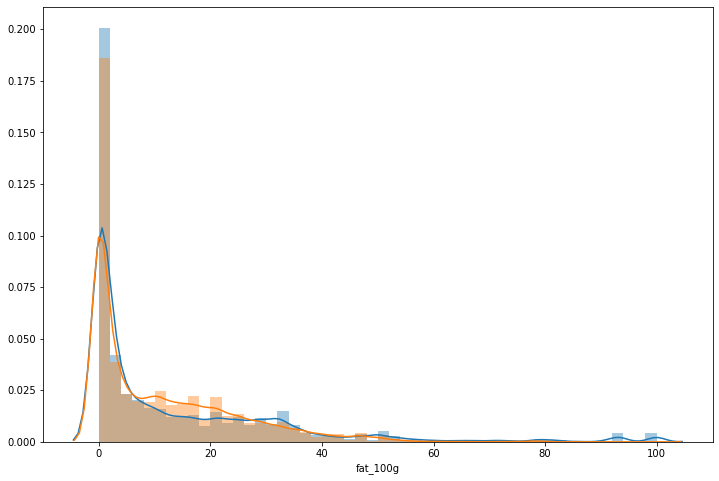

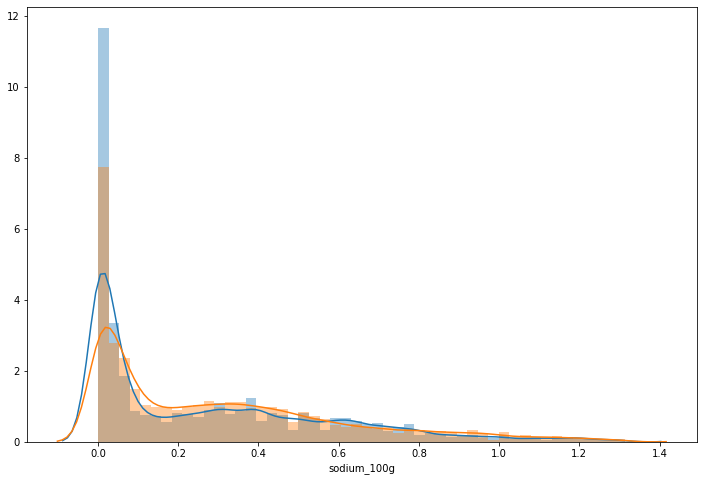

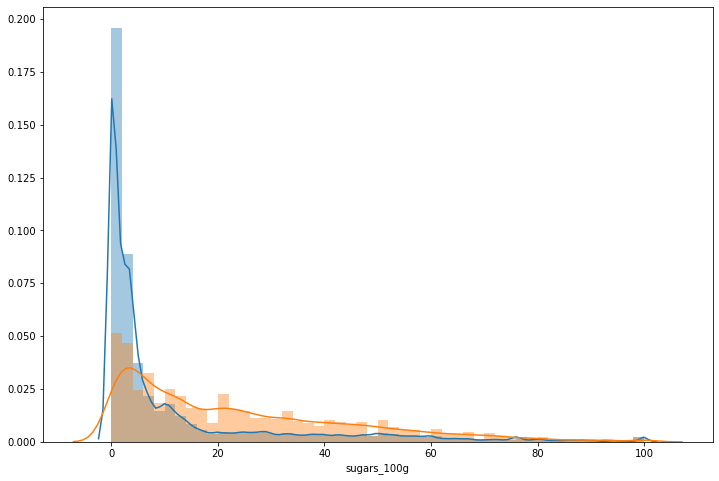

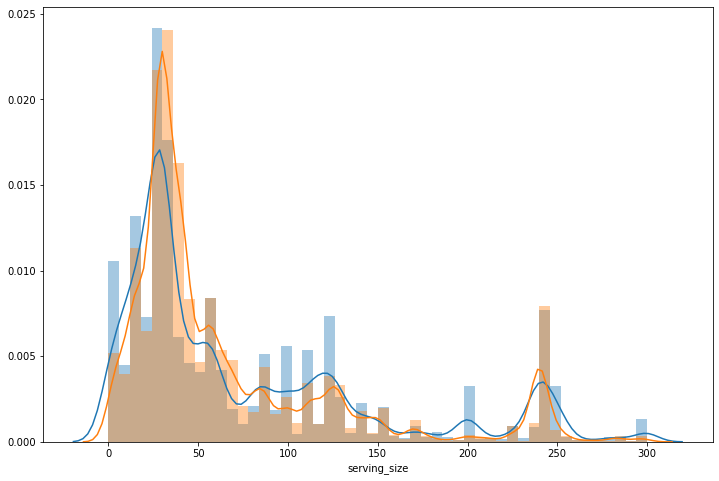

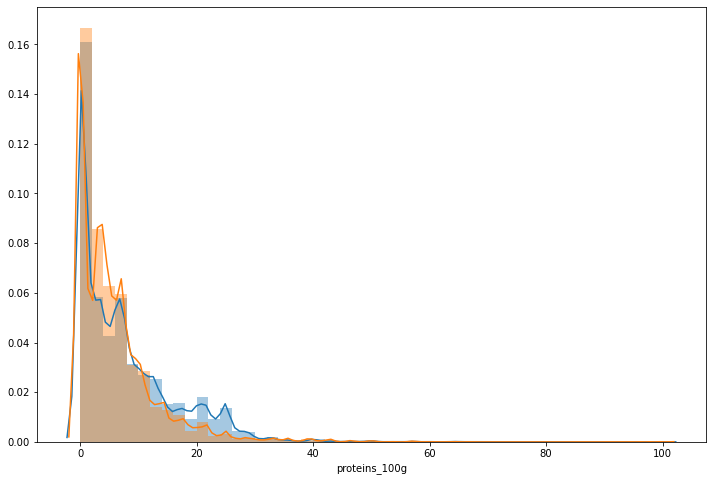

In [27]:
# Sucre ajouté et variables continues
for var in continues:
    plt.figure(figsize=(12,8))
    sns.distplot(ssa_df[var], label='Sans sucre ajoute')
    sns.distplot(sa_df[var], label='Avec sucre ajoute')
    plt.legend()

**Analyse: sucre ajouté et variables principales.**<br/>
On constate que les distributions sont semblables pour les produits qui contiennent du sucre ajouté et ceux qui n'en contiennent pas à l'exception de la variable sugars_100g. En effet, pour cette variable on constate une distribution différente entre les produits qui contiennent du sucre ajouté et ceux qui n'en contiennent: la queue de la distribution est plus épaisse vers les valeurs élevées de sugars_100g pour les produits qui contiennent du sucre ajouté que pour ceux qui n'en contiennent pas. 

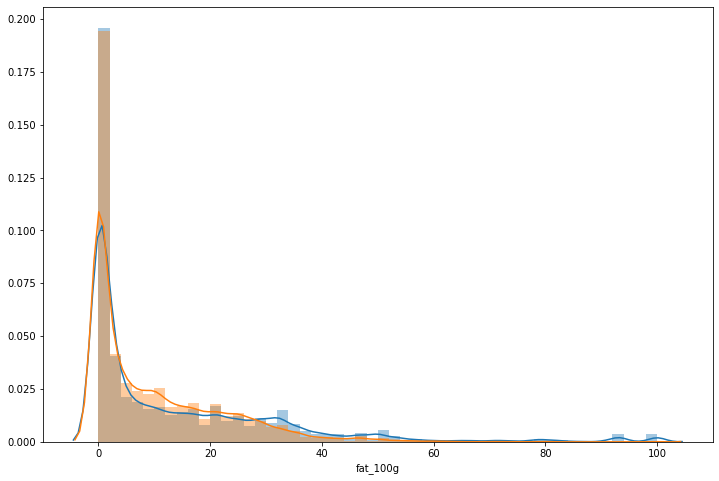

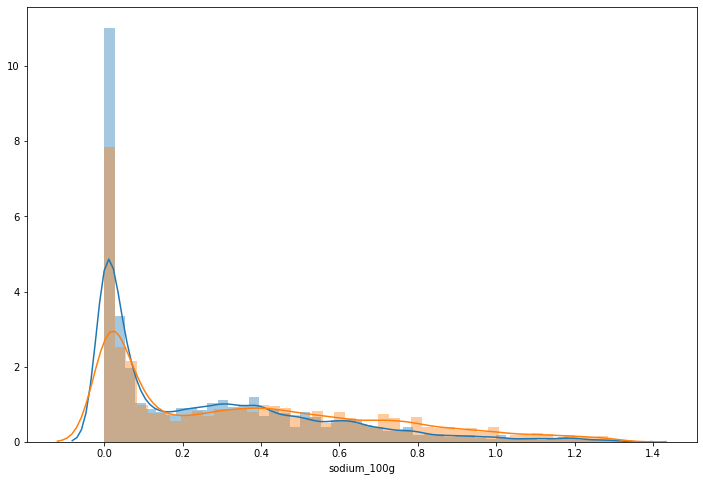

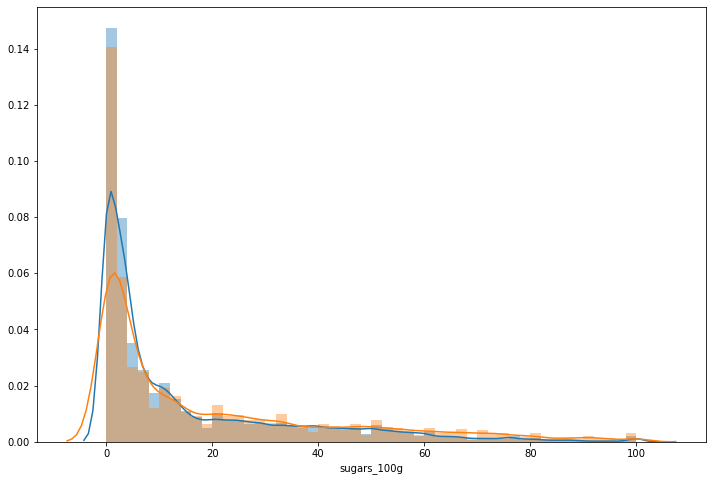

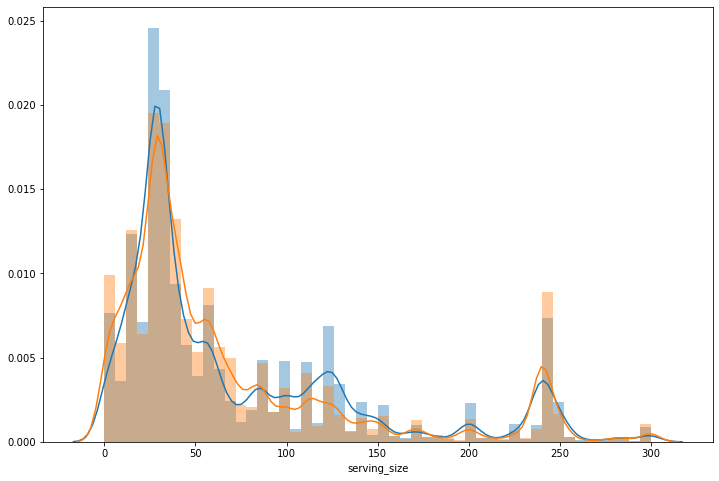

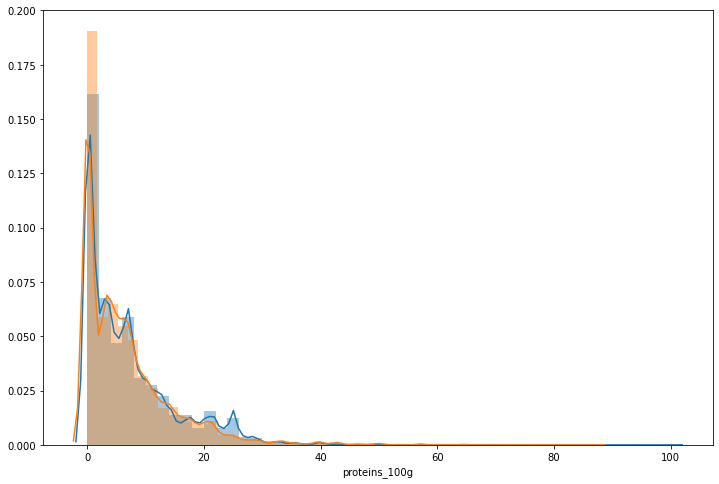

In [28]:
# Additifs nocifs et variables continues
for var in continues:
    plt.figure(figsize=(12,8))
    sns.distplot(san_df[var], label='Sans additif nocif')
    sns.distplot(an_df[var], label='Avec additifs nocifs')
    plt.legend()

**Analyse: additifs nocifs et variables principales.**<br/>
Ici, toutes les distributions sont très semblables quelque soit la variable et que les produits contiennent au moins un additif nocif ou non.

### Hypothèses et tests

---
**Récupération des données**

In [1]:
import pickle

with open("transfer_df_new","rb") as fichier:
    df_new_depickler=pickle.Unpickler(fichier)
    df_new=df_new_depickler.load()

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import exploration as ex
import numpy as np
import seaborn as sns

**Fin récupération**

---

In [2]:
df_anova = df_new.copy()

Dans cette partie nous n'allons tester qu'une hypothèse par ANOVA. L'hypothèse que nous allons tester est une traduction de la question suivante: "Est-ce que la masse de sucre contenue dans un aliment est différente selon le nombre d'additifs que contient l'alliment?". Nous allons tester cette hypothèse par ANOVA. Afin d'avoir des effectifs assez conséquents tout en équilibrant les échantillons nous n'allons comparer les masses de sucres que pour les produits ayant entre 0 et 5 additifs.

**Test par ANOVA**
$$ 
\begin{cases}
H0:μ_0=μ_1=...=μ_5 \text{ où les μ sont les masses moyennes de sucre} \\
H1:\text{Au moins deux moyennes sont différentes}\\
\end{cases}
$$

In [3]:
from scipy.stats import f_oneway

In [5]:
sample0 = df_anova.loc[df_anova.additives_n==0, 'sugars_100g'].dropna()
sample1 = df_anova.loc[df_anova.additives_n==1, 'sugars_100g'].dropna()
sample2 = df_anova.loc[df_anova.additives_n==2, 'sugars_100g'].dropna()
sample3 = df_anova.loc[df_anova.additives_n==3, 'sugars_100g'].dropna()
sample4 = df_anova.loc[df_anova.additives_n==4, 'sugars_100g'].dropna()
sample5 = df_anova.loc[df_anova.additives_n==5, 'sugars_100g'].dropna()

In [9]:
liste_sample = [sample0, sample1, sample2, sample3, sample4, sample5]
taille_sample=[]
for samp in liste_sample:
    taille_sample.append(len(samp))
n_min = min(taille_sample)
alpha = 0.05 # Niveau de test
nb_individus_paquet = 250 # Nombre d'individus par paquet
nb_paquets = int(n_min/nb_individus_paquet) # Nombre de paquets à faire
nb_rejet = 0 # Nombre de rejet de H0
    
for i in range(nb_paquets):
    p_valeur = f_oneway(sample0[i*nb_individus_paquet:(i+1)*nb_individus_paquet+1],
                        sample1[i*nb_individus_paquet:(i+1)*nb_individus_paquet+1],
                        sample2[i*nb_individus_paquet:(i+1)*nb_individus_paquet+1],
                        sample3[i*nb_individus_paquet:(i+1)*nb_individus_paquet+1],
                        sample4[i*nb_individus_paquet:(i+1)*nb_individus_paquet+1],
                        sample5[i*nb_individus_paquet:(i+1)*nb_individus_paquet+1]).pvalue
    if p_valeur<=alpha:
        nb_rejet+=1
        
print(nb_paquets," paquets ont été testés.")
print("La proportion de rejet de H0 est: ",nb_rejet/nb_paquets)

40  paquets ont été testés.
La proportion de rejet de H0 est:  0.975


**Analyse:**<br/>
Au niveau de test $\alpha$ = 5% on a rejeté dans 97,5% des cas l'hypothèse nulle. Autrement dit, on peut affirmer que le nombre d'additifs a une influence sur la quantité de sucre d'un aliment. On peut raisonnablement supposer que l'influence du nombre d'additifs sur la masse de sucre d'un aliment est plutôt négative, c'est-à-dire que plus un aliment a d'additifs plus il a de chance de contenir beaucoup de sucres.

**Distribution de la variable sucre en fonction du nombre d'additifs**

In [13]:
import pickle

with open("transfer_df_new","rb") as fichier:
    df_new_depickler=pickle.Unpickler(fichier)
    df_new=df_new_depickler.load()

#%matplotlib inline
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
#import seaborn as sns

In [14]:
df_int = df_new.copy()

In [15]:
#from ipywidgets import (widgets, interact, interactive)

In [16]:
def plot_sucre_additifs(**arg):
    nombre_additifs = arg['nombre_additifs']
    plt.figure(figsize=(10,6))
    sns.distplot(df_int.loc[df_int.additives_n==nombre_additifs,'sugars_100g'],color='m')
    plt.title('Distribution de la variable sucre pour {} additifs'.format(nombre_additifs))

In [17]:
additifs_widget = widgets.IntSlider(value=0,
                                   min=0,
                                   max=31,
                                   description='Additifs',
                                   continuous_update=False)

In [18]:
interactive(plot_sucre_additifs,
            nombre_additifs=additifs_widget)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Additifs', max=31), Output()), …

## III. C. Un nouveau nutriscore

**Objectif de cette sous-partie:**<br/>
Dans cette sous-partie, on va effectuer une nouvelle classification supervisée mais cette fois-ci, avec les variables **sucre_ajoute** et **additifs_nocifs**. Dans l'idéal, on aimerait pouvoir faire 5 clusters afin de comparer ces 5 clusters avec les 5 notes du nutriscore classique. On discutera ensuite de la pertinence de ce potentiel nouveau nutriscore qui prendra en compte le sucre ajoute ainsi que les additifs nocifs dans les aliments.

---
**Récupération des variables**

In [1]:
import pickle

with open("transfer_df_new","rb") as fichier:
    df_new_depickler=pickle.Unpickler(fichier)
    df_new=df_new_depickler.load()
    
with open("transfer_data","rb") as fichier:
    data_depickler=pickle.Unpickler(fichier)
    data=data_depickler.load()

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import exploration as ex
import numpy as np
import seaborn as sns

**Fin récupération**

---

### Classification non supervisée

Dans un premier temps, on prépare les données pour effectuer le clustering.

In [2]:
cluster_new = df_new.copy()

In [4]:
# On supprime les variables qualitatives
for col in cluster_new.columns:
    if cluster_new[col].dtypes == object:
        cluster_new.drop(col, axis=1, inplace=True)

**Demarche de traitement des valeurs manquantes:**<br/>
On a mis en avant grâce au premier clustering les éventuels problèmes liés à l'imputation par des zéros des valeurs manquantes. Par exemple, les nutriscore A avaient des portions recommandées aussi faibles que les nutriscores D et E. Pour cette nouvelle classification on va, dans l'ordre suivant, garder en mémoire les moyennes de chaque colonne, imputer des valeurs extrèmes, enlever 5% des outliers du tableau qui seront majoritairement les valeurs extrèmes imputées et enfin on remplacera les valeurs extrèmes par les moyennes des colonnes qu'on aura stockées dans un dictionnaire. 

In [6]:
# IsolationForest pour enlever les outliers et KMeans pour le clustering
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

In [7]:
def imputation(df):
    
    # Moyennes des colonnes avant l'impuation des -999
    dict_moyennes = {col:df[col].mean() for col in df.columns}
    print(dict_moyennes)
    
    # On impute des valeurs extrèmes puis on enlève 5% des outliers
    df = df.fillna(-999)
    X = df.values
    model = IsolationForest(random_state=0, contamination = 0.05)
    model.fit(X)
    df = df[model.predict(X) == 1]
    
    # On remplace les valeurs extrèmes restantes par les moyennes des colonnes
    for col, moyenne in dict_moyennes.items():
        df[col].replace([-999],[moyenne],inplace=True)
        
    return df

In [8]:
def preprocessing(df):
    df = imputation(df)
    X = df
    return X

**Affichage suivant:**<br/>
L'affichage suivant est pour s'assurer que le dictionnaire voulu a bien été créé.

In [9]:
# X est le tableau initial sans les outliers et avec les moyennes imputées
X_new = preprocessing(cluster_new)

# X_kmeans ne contient pas 'nutrition_grade_fr'
X_kmeans = X_new.drop('nutrition_grade_fr', axis=1)

{'fat_100g': 12.717748275643366, 'cholesterol_100g': 0.020070728791022122, 'sugars_100g': 15.982635926628923, 'fiber_100g': 1.9153013431474584, 'proteins_100g': 7.082702655771591, 'sodium_100g': 0.2831060530402664, 'vitamin-a_100g': 0.00039716457840056565, 'vitamin-c_100g': 0.014571029126503881, 'calcium_100g': 0.10211566572387411, 'iron_100g': 0.0036583471410844984, 'additives_n': 1.938608606714155, 'ingredients_from_palm_oil_n': 0.019706774153281172, 'nutrition_grade_fr': 2.1967229448208396, 'serving_size': 71.05784711017598, 'sucre_ajoute': 0.27240356083086054, 'additifs_nocifs': 0.2163267218491332}


Text(0, 0.5, 'Inertie')

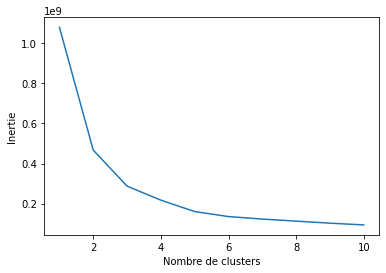

In [10]:
# Est-il pertinent de choisir 5 clusters ?
#inertie = []
#for k in range(1,11):
    #model = KMeans(n_clusters=k).fit(X_kmeans)
    #inertie.append(model.inertia_)

#plt.plot(range(1,11),inertie)
#plt.xlabel('Nombre de clusters')
#plt.ylabel('Inertie')

**Analyse:**<br/>
D'après la méthode du coude, il semble pertinent de choisir 5 clusters. En effet, on constate que pour 5 clusters, l'inertie de ces derniers est assez faible.

In [11]:
# 5 clusters 
model = KMeans(n_clusters=5)
model.fit(X_kmeans)
new_prediction = model.predict(X_kmeans)

In [12]:
# Le tableau initial 'préparé' contenant la colonne 'nutrition_grade_fr'
cluster_new = X_new

In [13]:
# On ajoute la colonne qui contient les clusters
cluster_new['clusters'] = new_prediction

In [14]:
# Tableau des coordonnées des centroïdes
new_centroides_df = pd.DataFrame(model.cluster_centers_, columns=X_kmeans.columns)

**Démarche:**<br/>
Afin de savoir comment faire le barème de notre nouveau nutriscore (i.e. attribuer une note à chaque cluster) on va afficher les positions des centroides de chaque groupes sur les axes **sucre_ajoute**, **additifs_nocifs**, **sugars_100g** et **serving_size** dont la seule
variable qui est prise en compte par le nutriscore classique est sugars_100g.

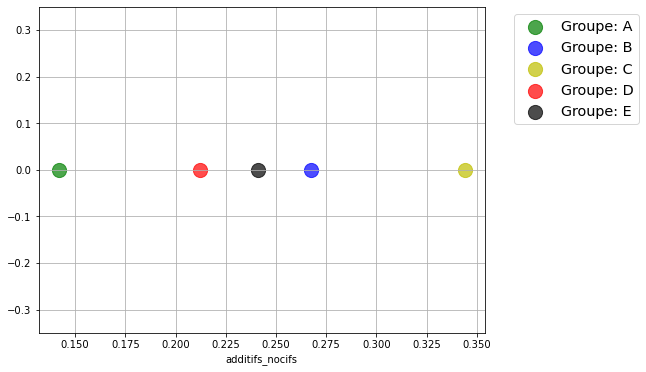

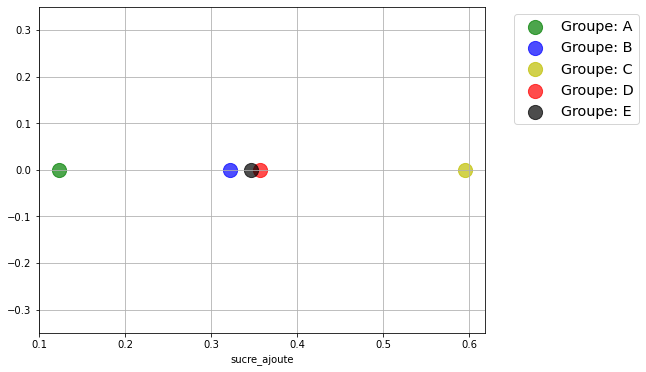

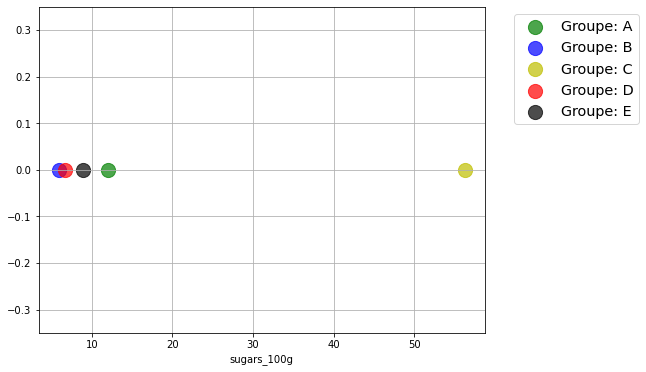

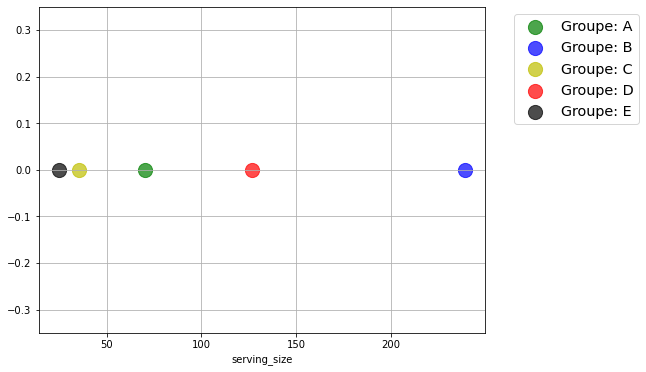

In [21]:
# Affichage des centroïdes sur les axes décrits ci-dessus

color_dict = [(0,'g','A'),
              (1,'b','B'),
              (2,'y','C'),
              (3,'r','D'),
              (4,'k','E')]

for col in ['additifs_nocifs','sucre_ajoute','sugars_100g','serving_size']:
    plt.figure(figsize=(8,6))
    for i1, color, n in color_dict:
        
        plt.scatter(new_centroides_df.loc[i1,col], 
                    np.zeros_like(new_centroides_df.loc[i1,col]), 
                    c=color, 
                    alpha=0.7,
                    label='Groupe: '+n,
                    s=200)
        plt.legend(loc='upper left', bbox_to_anchor=(1.05,1), fontsize='x-large')
        plt.margins(y=3)
        plt.xlabel(col)
        plt.grid()

**Analyse**<br/>
On s'appuie en priorité sur les variables que le nutriscore classique ne prend pas en compte, ainsi pour le nouveau nutriscore on a:
<ul><li>Le point vert = cluster n°0 = meilleur nutriscore</li>
    <li>Le point rouge = cluster n°3 = bon nutriscore</li>
    <li>Le point noir = cluster n°4 = nutriscore moyen</li>
    <li>Le point bleu = cluster n°1 = mauvais nutriscore</li>
    <li>Le point jaune = cluster n°2 = très mauvais nutriscore </li></ul>

**Remarque:**<br/>
Pour le point bleu, la portion recommandée est trop élevée.

---
**Enregistrement des variables relatives au clustering n°2**

In [15]:
import pickle

with open("transfer_new_centroides_df","wb") as fichier:
    new_centroides_df_pickler=pickle.Pickler(fichier)
    new_centroides_df_pickler.dump(new_centroides_df)
    

with open("transfer_new_prediction","wb") as fichier:
    new_prediction_pickler=pickle.Pickler(fichier)
    new_prediction_pickler.dump(new_prediction)
    

**Fin enregistrement**

---

### Comparaison du nouveau nutriscore avec l'original

**Objectif:**<br/>
Maintenant qu'on a établi notre nouveau nutriscore sur des critères différents du classique, nous allons comparer la répartition de ce nouveau nutriscore sur les différents axes qui correspondent au barème de l'ancien nutriscore à savoir: fat_100g, sugars_100g et sodium_100g. 

---
**Récupération des centroides du nutriscore classique**

In [22]:
import pickle

with open("transfer_centroides_nutriscore_df","rb") as fichier:
    centroides_nutriscore_df_depickler=pickle.Unpickler(fichier)
    centroides_nutriscore_df=centroides_nutriscore_df_depickler.load()

**Fin récupération**

---

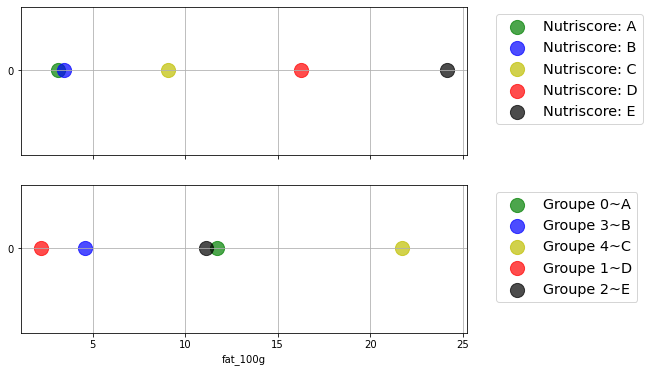

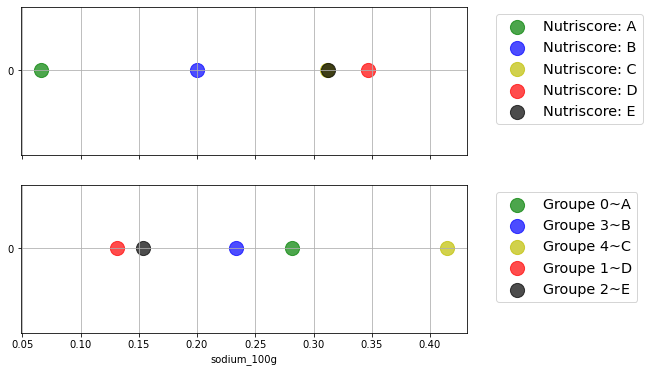

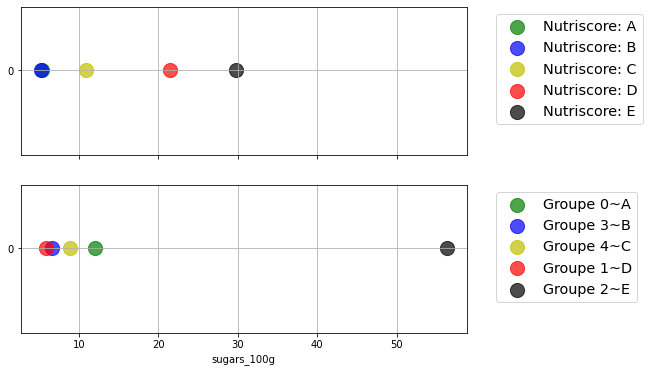

In [24]:
# Affichage des centroïdes sur les axes correspondants aux variables principales

color_dict = [(0,'g','A',0),
              (1,'b','B',3),
              (2,'y','C',4),
              (3,'r','D',1),
              (4,'k','E',2)]

for col in ['fat_100g','sodium_100g','sugars_100g']:
    fig, ax = plt.subplots(2,1,sharex=True, figsize=(8,6))
    for i1, color, n, i2 in color_dict:
        
        ax[0].scatter(centroides_nutriscore_df.loc[i1,col], 
                    np.zeros_like(centroides_nutriscore_df.loc[i1,col]), 
                    c=color, 
                    alpha=0.7,
                    label='Nutriscore: '+n,
                    s=200)
        ax[0].legend(loc='upper left', bbox_to_anchor=(1.05,1), fontsize='x-large')
        ax[0].margins(y=3)
        ax[0].set_yticks([0])
        ax[0].grid()
        

        ax[1].scatter(new_centroides_df.loc[i2,col], 
                    np.zeros_like(new_centroides_df.loc[i2,col]), 
                    c=color, 
                    alpha=0.7, 
                    label='Groupe ' + str(i2) + '~' + n, # cluster ~ nutriscore équivalent
                    s=200)
        ax[1].margins(y=3)
        ax[1].set_xlabel(col)
        ax[1].legend(loc='upper left', bbox_to_anchor=(1.05,1), fontsize='x-large')
        ax[1].set_yticks([0])
        ax[1].grid()


**Analyse.**<br/>
<ul><li>Pour la variable fat_100g. On constate que les nouveaux bons nutriscores n'ont pas forcément des taux de gras faibles. C'est normal, ce nouveau nutriscore est d'abord fondé sur les critères de sucre ajouté et d'additifs nocifs. Sur cette base, certains aliments relativement gras ne contiennent pas d'additif nocif ni de sucre ajouté et sont donc considérés comme bons par le nouveau nutriscore. On pourrait alors se demander, pour pousser l'analyse plus loin (de la même manière qu'avec le sucre), si le gras d'un produit a été ajouté ou s'il est contenu naturellement (comme pour les noix par exemple).</li>
    <li>Pour la variable sodium_100g. On peut faire le même constat que pour la variable fat_100g, certains produits assez salés sont considérés comme bon car ils n'ont pas d'additifs nocifs et pas de sucre ajouté.</li>
    <li>Pour la variable sugars_100g. On constate que tous les points se situent autour de x=10 sauf pour le plus mauvais nutriscore dont le point est très éloigné vers les abscisses élevés. La encore, la quantité de sucre ne semble par rentrer en compte. En effet, une pomme est naturellement sucré mais ne contient ni additifs ni sucre ajouté donc n'a pas de raison de se voir attribuer un mauvais nutriscore à cause de sa teneur naturelle en sucre.</li></ul>

### Conclusion de la partie III

Dans cette partie, nous avons d'abord extrait deux nouvelles variables à partir de la liste des ingrédients et de la liste des additifs de chaque aliment. Ces deux variables sont: additfs_nocifs et sucre_ajoute. Ce sont des variables binaires qui prennent la valeur "1" lorsque le produit contient au moins un additif nocif ou quand il contient du sucre ajouté. Pour déterminer si le produit contient un additif nocif nous avons extrait du site <a>https://www.quechoisir.org/comparatif-additifs-alimentaires-n56877/?f4%5B%5D=EQpicto-3-orange.png&f4%5B%5D=EQpicto-4-rouge.png#filtres</a> le tableau des additifs nocifs ou non recommandés. Ces deux variables ont changé la dynamique du tableau comme nous l'avons constaté lors de l'analyse en composante principale (ACP). Après cette ACP, nous avons effectué une analyse plus précise entre les variables principales de notre tableau et nos deux nouvelles variables cibles. Nous avons ainsi dégagé 2 hypothèses [...]. Pour conclure cette partie nous avons tenté, à partir de ce nouveau tableau, d'établir un nouveau nutriscore qui prend en compte les additifs nocifs et le sucre ajouté des aliments. Bien que ce nouveau nutriscore donne des résultats cohérents il pourrait encore largement être amélioré. Pour cela, il faudrait par exemple faire une extraction de variables plus poussée en analysant plus en détail la liste des ingrédients. 

# Annexe

**Qu'est-ce qu'un aliment industriel ?**<br/>
Un aliment industriel est un aliment transformé par processus industriel pour changer ses caractéristiques de saveur, de conservation, d’odeur, de couleur, de forme et de comportement face à la température (les filaments du fromage qu’on retrouve sur les pizzas industrielles par exemple). Un aliment industriel est généralement composé d’autres aliments transformés.<br/>
La définition donnée sur Wikipédia est la suivante: "*Un aliment industriel est un aliment conditionné et transformé par l'industrie agroalimentaire à partir de produits agricoles comme les aliments simples (viande, légumes..) mais aussi d'additifs alimentaires et d'auxiliaires technologiques.*" [12]

<div id=cracking><strong>Pourquoi lorsque le taux de protéines augmentent, le nombre d'additifs ainsi que les chances que le produit contienne du sucre ajouté et des additifs nocifs diminuent ?</strong><br/>
On va répondre à cette question en deux parties.<br/>
Premièrement, "le mot protéine vient du grec ancien prôtos qui signifie premier, essentiel" (Wikipédia). Cette signification est justement l'exacte contraire de ce que sont les additifs et les sucres ajoutés. D'ailleurs on retrouve dans ces derniers, de manière presque explicite, le verbe "ajouter". En effet, les aliments qui contiennent des additifs et/ou des sucres ajoutés sont ceux qui correspondent parfaitement à la définition d'un <a href=#def_aliment_indus>"produit industriel"</a>. Le fait de modifier un aliment par processus industriel porte un nom: <strong>le cracking</strong> (lien d'un reportage de France 2 pour en apprendre plus sur le sujet <a>https://www.youtube.com/watch?v=uCVly_8M5f8</a>). Aucun produit cracké n'est essentiel dans notre alimentation. <br/>
Deuxièmement, les protéines en elles-mêmes n'apportent rien d'un point de vue plaisir gustatif. C'est la bonne association du gras et du sucre qui procure le plus de plaisir en bouche. D'ailleurs, il existe un terme qui désigne la composotion parfaite d'un aliment industriel: le point de félicité (<a>https://www.allodocteurs.fr/alimentation/alimentation-a-la-recherche-du-point-f_19036.html</a> lien d'un article sur le sujet, rédigé par un psychologue nutritionniste). Voilà pourquoi on retrouve les aliments protéinés à l'opposé des aliments modifiés industriellement.</div>

**Références:**
1. OMS recommandation sucre https://www.who.int/mediacentre/news/releases/2015/sugar-guideline/fr/
2.  https://nutriscore.colruytgroup.com/colruytgroup/fr/nutri-score-calculateur/
3. https://quoidansmonassiette.fr/comment-est-calcule-le-nutri-score-logo-nutritionnel/
4. https://fr.wikipedia.org/wiki/Sel_alimentaire
5. https://www.futura-sciences.com/sante/definitions/medecine-acide-gras-9/
6. https://www.passeportsante.net/fr/Nutrition/PalmaresNutriments/Fiche.aspx?doc=glucides
7. https://www.doctissimo.fr/html/sante/mag_2002/sem01/mag0517/dossier/sa_5497_fertilite_zinc_acide.htm
8. https://www.passionsante.be/index.cfm?fuseaction=art&art_id=25410
9. http://www.sante-et-nutrition.com/deficit-zinc/
10. https://www.runtastic.com/blog/fr/que-sont-les-macronutriments/
11. https://www.economie.gouv.fr/files/directions_services/daj/marches_publics/oeap/gem/nutrition/nutrition.pdf
12. https://fr.wikipedia.org/wiki/Aliment_industriel#:~:text=Un%20aliment%20industriel%20est%20un,alimentaires%20et%20d'auxiliaires%20technologiques.